In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
import numpy as np
from util import getHashId, pickleLoad

feature_selection = pickleLoad('data/feature_selection.pkl')
features_oc = np.load('data/preprocessed/features_vox.npy')
exc = 10
features = [f for f in features_oc if f not in feature_selection['excludeds'][exc][np.argmax(feature_selection['accuracies'][exc])]]

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : features,
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_firstorder_TotalEnergy_firstorder_Minimum_firstorder_10Percentile_firstorder_Median_firstorder_InterquartileRange_firstorder_Range_firstorder_RobustMeanAbsoluteDeviation_firstorder_RootMeanSquared_firstorder_Skewness_firstorder_Kurtosis_firstorder_Variance_firstorder_Uniformity_glcm_JointAverage_glcm_ClusterProminence_glcm_ClusterShade_glcm_ClusterTendency_glcm_Contrast_glcm_Correlation_glcm_DifferenceAverage_glcm_DifferenceEntropy_glcm_DifferenceVariance_glcm_JointEnergy_glcm_JointEntropy_glcm_Imc2_glcm_Idm_glcm_MCC_glcm_Idmn_glcm_Id_glcm_Idn_glcm_InverseVariance_glcm_MaximumProbability_glcm_SumEntropy_glcm_SumSquares_glszm_SmallAreaEmphasis_glszm_LargeAreaEmphasis_glszm_GrayLevelNonUniformity_glszm_GrayLevelNonUniformityNormalized_glszm_SizeZoneNonUniformity_glszm_SizeZoneNonUniformityNormalized_glszm_ZonePercentage_glszm_GrayLevelVariance_glszm_ZoneVariance_glszm_ZoneEntropy_glszm_HighGrayLevelZoneEmphasis_glszm

In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 738)
(3944610, 8)
validation
(464344, 738)
(464344, 8)
test
(574820, 738)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 738)]             0         


 dense (Dense)               (None, 1024)              756736    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1446792 (5.52 MB)


Trainable params: 1446792 (5.52 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/395 [..............................] - ETA: 11:11 - loss: 2.2174 - STD: 0.0613 - MAE: 0.2196

  4/395 [..............................] - ETA: 8s - loss: 2.1098 - STD: 0.0525 - MAE: 0.2168   

  7/395 [..............................] - ETA: 8s - loss: 2.0998 - STD: 0.0508 - MAE: 0.2165

 10/395 [..............................] - ETA: 8s - loss: 2.0880 - STD: 0.0456 - MAE: 0.2166

 13/395 [..............................] - ETA: 8s - loss: 2.0796 - STD: 0.0429 - MAE: 0.2166

 16/395 [>.............................] - ETA: 8s - loss: 2.0756 - STD: 0.0415 - MAE: 0.2166

 19/395 [>.............................] - ETA: 7s - loss: 2.0714 - STD: 0.0397 - MAE: 0.2166

 22/395 [>.............................] - ETA: 7s - loss: 2.0680 - STD: 0.0387 - MAE: 0.2166

 25/395 [>.............................] - ETA: 7s - loss: 2.0653 - STD: 0.0385 - MAE: 0.2166

 28/395 [=>............................] - ETA: 7s - loss: 2.0630 - STD: 0.0381 - MAE: 0.2165

 31/395 [=>............................] - ETA: 7s - loss: 2.0601 - STD: 0.0372 - MAE: 0.2165

 34/395 [=>............................] - ETA: 7s - loss: 2.0568 - STD: 0.0367 - MAE: 0.2164

 37/395 [=>............................] - ETA: 7s - loss: 2.0527 - STD: 0.0366 - MAE: 0.2163

 40/395 [==>...........................] - ETA: 7s - loss: 2.0474 - STD: 0.0365 - MAE: 0.2161

 43/395 [==>...........................] - ETA: 7s - loss: 2.0405 - STD: 0.0370 - MAE: 0.2158

 46/395 [==>...........................] - ETA: 7s - loss: 2.0320 - STD: 0.0381 - MAE: 0.2154

 49/395 [==>...........................] - ETA: 7s - loss: 2.0217 - STD: 0.0398 - MAE: 0.2149

 52/395 [==>...........................] - ETA: 7s - loss: 2.0102 - STD: 0.0417 - MAE: 0.2143

 55/395 [===>..........................] - ETA: 7s - loss: 1.9973 - STD: 0.0438 - MAE: 0.2137

 58/395 [===>..........................] - ETA: 7s - loss: 1.9831 - STD: 0.0459 - MAE: 0.2129

 61/395 [===>..........................] - ETA: 7s - loss: 1.9679 - STD: 0.0482 - MAE: 0.2121

 64/395 [===>..........................] - ETA: 7s - loss: 1.9519 - STD: 0.0507 - MAE: 0.2112

 67/395 [====>.........................] - ETA: 6s - loss: 1.9353 - STD: 0.0533 - MAE: 0.2103

 70/395 [====>.........................] - ETA: 6s - loss: 1.9194 - STD: 0.0559 - MAE: 0.2093

 73/395 [====>.........................] - ETA: 6s - loss: 1.9041 - STD: 0.0586 - MAE: 0.2084

 76/395 [====>.........................] - ETA: 6s - loss: 1.8891 - STD: 0.0613 - MAE: 0.2074

 79/395 [=====>........................] - ETA: 6s - loss: 1.8747 - STD: 0.0639 - MAE: 0.2064

 82/395 [=====>........................] - ETA: 6s - loss: 1.8610 - STD: 0.0663 - MAE: 0.2055

 85/395 [=====>........................] - ETA: 6s - loss: 1.8476 - STD: 0.0687 - MAE: 0.2047

 88/395 [=====>........................] - ETA: 6s - loss: 1.8353 - STD: 0.0708 - MAE: 0.2038

 91/395 [=====>........................] - ETA: 6s - loss: 1.8233 - STD: 0.0728 - MAE: 0.2031

 94/395 [======>.......................] - ETA: 6s - loss: 1.8118 - STD: 0.0748 - MAE: 0.2023

 97/395 [======>.......................] - ETA: 6s - loss: 1.8005 - STD: 0.0767 - MAE: 0.2015

100/395 [======>.......................] - ETA: 6s - loss: 1.7897 - STD: 0.0786 - MAE: 0.2008

103/395 [======>.......................] - ETA: 6s - loss: 1.7795 - STD: 0.0804 - MAE: 0.2001

106/395 [=======>......................] - ETA: 6s - loss: 1.7695 - STD: 0.0821 - MAE: 0.1994

109/395 [=======>......................] - ETA: 6s - loss: 1.7597 - STD: 0.0838 - MAE: 0.1987

112/395 [=======>......................] - ETA: 6s - loss: 1.7503 - STD: 0.0854 - MAE: 0.1980

115/395 [=======>......................] - ETA: 5s - loss: 1.7414 - STD: 0.0870 - MAE: 0.1974

118/395 [=======>......................] - ETA: 5s - loss: 1.7327 - STD: 0.0885 - MAE: 0.1968

121/395 [========>.....................] - ETA: 5s - loss: 1.7242 - STD: 0.0900 - MAE: 0.1961

124/395 [========>.....................] - ETA: 5s - loss: 1.7159 - STD: 0.0914 - MAE: 0.1955

127/395 [========>.....................] - ETA: 5s - loss: 1.7080 - STD: 0.0928 - MAE: 0.1950

130/395 [========>.....................] - ETA: 5s - loss: 1.7002 - STD: 0.0941 - MAE: 0.1944

133/395 [=========>....................] - ETA: 5s - loss: 1.6926 - STD: 0.0955 - MAE: 0.1938

136/395 [=========>....................] - ETA: 5s - loss: 1.6851 - STD: 0.0967 - MAE: 0.1932

139/395 [=========>....................] - ETA: 5s - loss: 1.6778 - STD: 0.0980 - MAE: 0.1927

142/395 [=========>....................] - ETA: 5s - loss: 1.6706 - STD: 0.0992 - MAE: 0.1921

145/395 [==========>...................] - ETA: 5s - loss: 1.6635 - STD: 0.1004 - MAE: 0.1916

148/395 [==========>...................] - ETA: 5s - loss: 1.6569 - STD: 0.1016 - MAE: 0.1911

151/395 [==========>...................] - ETA: 5s - loss: 1.6504 - STD: 0.1027 - MAE: 0.1906

154/395 [==========>...................] - ETA: 5s - loss: 1.6442 - STD: 0.1038 - MAE: 0.1901

157/395 [==========>...................] - ETA: 5s - loss: 1.6380 - STD: 0.1049 - MAE: 0.1896

160/395 [===========>..................] - ETA: 4s - loss: 1.6319 - STD: 0.1059 - MAE: 0.1891

163/395 [===========>..................] - ETA: 4s - loss: 1.6258 - STD: 0.1069 - MAE: 0.1887

166/395 [===========>..................] - ETA: 4s - loss: 1.6199 - STD: 0.1079 - MAE: 0.1882

169/395 [===========>..................] - ETA: 4s - loss: 1.6140 - STD: 0.1089 - MAE: 0.1877

172/395 [============>.................] - ETA: 4s - loss: 1.6085 - STD: 0.1099 - MAE: 0.1873

175/395 [============>.................] - ETA: 4s - loss: 1.6029 - STD: 0.1109 - MAE: 0.1868

178/395 [============>.................] - ETA: 4s - loss: 1.5975 - STD: 0.1118 - MAE: 0.1864

181/395 [============>.................] - ETA: 4s - loss: 1.5923 - STD: 0.1127 - MAE: 0.1860

184/395 [============>.................] - ETA: 4s - loss: 1.5871 - STD: 0.1136 - MAE: 0.1855

187/395 [=============>................] - ETA: 4s - loss: 1.5823 - STD: 0.1145 - MAE: 0.1851

190/395 [=============>................] - ETA: 4s - loss: 1.5773 - STD: 0.1154 - MAE: 0.1847

193/395 [=============>................] - ETA: 4s - loss: 1.5725 - STD: 0.1163 - MAE: 0.1843

196/395 [=============>................] - ETA: 4s - loss: 1.5677 - STD: 0.1171 - MAE: 0.1839

199/395 [==============>...............] - ETA: 4s - loss: 1.5630 - STD: 0.1179 - MAE: 0.1835

202/395 [==============>...............] - ETA: 4s - loss: 1.5585 - STD: 0.1187 - MAE: 0.1831

205/395 [==============>...............] - ETA: 4s - loss: 1.5540 - STD: 0.1195 - MAE: 0.1828

208/395 [==============>...............] - ETA: 3s - loss: 1.5496 - STD: 0.1202 - MAE: 0.1824

211/395 [===============>..............] - ETA: 3s - loss: 1.5454 - STD: 0.1210 - MAE: 0.1820

214/395 [===============>..............] - ETA: 3s - loss: 1.5412 - STD: 0.1217 - MAE: 0.1817

217/395 [===============>..............] - ETA: 3s - loss: 1.5371 - STD: 0.1224 - MAE: 0.1813

220/395 [===============>..............] - ETA: 3s - loss: 1.5330 - STD: 0.1231 - MAE: 0.1810

223/395 [===============>..............] - ETA: 3s - loss: 1.5290 - STD: 0.1238 - MAE: 0.1806

226/395 [================>.............] - ETA: 3s - loss: 1.5250 - STD: 0.1245 - MAE: 0.1803

229/395 [================>.............] - ETA: 3s - loss: 1.5213 - STD: 0.1252 - MAE: 0.1800

232/395 [================>.............] - ETA: 3s - loss: 1.5175 - STD: 0.1258 - MAE: 0.1796

235/395 [================>.............] - ETA: 3s - loss: 1.5141 - STD: 0.1265 - MAE: 0.1793

238/395 [=================>............] - ETA: 3s - loss: 1.5105 - STD: 0.1271 - MAE: 0.1790

241/395 [=================>............] - ETA: 3s - loss: 1.5069 - STD: 0.1277 - MAE: 0.1787

244/395 [=================>............] - ETA: 3s - loss: 1.5034 - STD: 0.1283 - MAE: 0.1784

247/395 [=================>............] - ETA: 3s - loss: 1.5001 - STD: 0.1289 - MAE: 0.1781

250/395 [=================>............] - ETA: 3s - loss: 1.4967 - STD: 0.1295 - MAE: 0.1778

253/395 [==================>...........] - ETA: 3s - loss: 1.4934 - STD: 0.1301 - MAE: 0.1775

256/395 [==================>...........] - ETA: 2s - loss: 1.4902 - STD: 0.1306 - MAE: 0.1773

259/395 [==================>...........] - ETA: 2s - loss: 1.4870 - STD: 0.1312 - MAE: 0.1770

262/395 [==================>...........] - ETA: 2s - loss: 1.4842 - STD: 0.1317 - MAE: 0.1767

265/395 [===================>..........] - ETA: 2s - loss: 1.4812 - STD: 0.1323 - MAE: 0.1765

268/395 [===================>..........] - ETA: 2s - loss: 1.4783 - STD: 0.1328 - MAE: 0.1762

271/395 [===================>..........] - ETA: 2s - loss: 1.4755 - STD: 0.1333 - MAE: 0.1760

274/395 [===================>..........] - ETA: 2s - loss: 1.4726 - STD: 0.1338 - MAE: 0.1757

277/395 [====================>.........] - ETA: 2s - loss: 1.4697 - STD: 0.1343 - MAE: 0.1755

280/395 [====================>.........] - ETA: 2s - loss: 1.4668 - STD: 0.1348 - MAE: 0.1752

283/395 [====================>.........] - ETA: 2s - loss: 1.4641 - STD: 0.1353 - MAE: 0.1750

286/395 [====================>.........] - ETA: 2s - loss: 1.4615 - STD: 0.1357 - MAE: 0.1747

289/395 [====================>.........] - ETA: 2s - loss: 1.4587 - STD: 0.1362 - MAE: 0.1745

292/395 [=====================>........] - ETA: 2s - loss: 1.4560 - STD: 0.1367 - MAE: 0.1743

295/395 [=====================>........] - ETA: 2s - loss: 1.4533 - STD: 0.1371 - MAE: 0.1740

298/395 [=====================>........] - ETA: 2s - loss: 1.4506 - STD: 0.1376 - MAE: 0.1738

301/395 [=====================>........] - ETA: 1s - loss: 1.4481 - STD: 0.1380 - MAE: 0.1736

304/395 [======================>.......] - ETA: 1s - loss: 1.4456 - STD: 0.1384 - MAE: 0.1733

307/395 [======================>.......] - ETA: 1s - loss: 1.4432 - STD: 0.1388 - MAE: 0.1731

310/395 [======================>.......] - ETA: 1s - loss: 1.4409 - STD: 0.1393 - MAE: 0.1729

313/395 [======================>.......] - ETA: 1s - loss: 1.4386 - STD: 0.1397 - MAE: 0.1727

316/395 [=======================>......] - ETA: 1s - loss: 1.4361 - STD: 0.1401 - MAE: 0.1725

319/395 [=======================>......] - ETA: 1s - loss: 1.4337 - STD: 0.1405 - MAE: 0.1723

322/395 [=======================>......] - ETA: 1s - loss: 1.4314 - STD: 0.1409 - MAE: 0.1721

325/395 [=======================>......] - ETA: 1s - loss: 1.4290 - STD: 0.1413 - MAE: 0.1719

328/395 [=======================>......] - ETA: 1s - loss: 1.4266 - STD: 0.1417 - MAE: 0.1717

331/395 [========================>.....] - ETA: 1s - loss: 1.4243 - STD: 0.1421 - MAE: 0.1715

334/395 [========================>.....] - ETA: 1s - loss: 1.4220 - STD: 0.1424 - MAE: 0.1713

337/395 [========================>.....] - ETA: 1s - loss: 1.4200 - STD: 0.1428 - MAE: 0.1711

340/395 [========================>.....] - ETA: 1s - loss: 1.4178 - STD: 0.1432 - MAE: 0.1709

343/395 [=========================>....] - ETA: 1s - loss: 1.4158 - STD: 0.1436 - MAE: 0.1707

346/395 [=========================>....] - ETA: 1s - loss: 1.4138 - STD: 0.1439 - MAE: 0.1705

349/395 [=========================>....] - ETA: 0s - loss: 1.4118 - STD: 0.1443 - MAE: 0.1703

352/395 [=========================>....] - ETA: 0s - loss: 1.4097 - STD: 0.1446 - MAE: 0.1701

355/395 [=========================>....] - ETA: 0s - loss: 1.4078 - STD: 0.1450 - MAE: 0.1700

358/395 [==========================>...] - ETA: 0s - loss: 1.4060 - STD: 0.1453 - MAE: 0.1698

361/395 [==========================>...] - ETA: 0s - loss: 1.4041 - STD: 0.1456 - MAE: 0.1696

364/395 [==========================>...] - ETA: 0s - loss: 1.4022 - STD: 0.1460 - MAE: 0.1694

367/395 [==========================>...] - ETA: 0s - loss: 1.4003 - STD: 0.1463 - MAE: 0.1693

370/395 [===========================>..] - ETA: 0s - loss: 1.3985 - STD: 0.1466 - MAE: 0.1691

373/395 [===========================>..] - ETA: 0s - loss: 1.3966 - STD: 0.1469 - MAE: 0.1689

376/395 [===========================>..] - ETA: 0s - loss: 1.3947 - STD: 0.1473 - MAE: 0.1688

379/395 [===========================>..] - ETA: 0s - loss: 1.3927 - STD: 0.1476 - MAE: 0.1686

382/395 [============================>.] - ETA: 0s - loss: 1.3908 - STD: 0.1479 - MAE: 0.1684

385/395 [============================>.] - ETA: 0s - loss: 1.3890 - STD: 0.1482 - MAE: 0.1683

388/395 [============================>.] - ETA: 0s - loss: 1.3872 - STD: 0.1485 - MAE: 0.1681

391/395 [============================>.] - ETA: 0s - loss: 1.3854 - STD: 0.1488 - MAE: 0.1679

392/395 [============================>.] - ETA: 0s - loss: 1.3851 - STD: 0.1489 - MAE: 0.1679

395/395 [==============================] - ETA: 0s - loss: 1.3833 - STD: 0.1492 - MAE: 0.1677

395/395 [==============================] - 12s 27ms/step - loss: 1.3833 - STD: 0.1492 - MAE: 0.1677 - val_loss: 1.1861 - val_STD: 0.1886 - val_MAE: 0.1469


Epoch 2/10000


  1/395 [..............................] - ETA: 17s - loss: 1.1652 - STD: 0.1874 - MAE: 0.1475

  4/395 [..............................] - ETA: 8s - loss: 1.1575 - STD: 0.1873 - MAE: 0.1472 

  7/395 [..............................] - ETA: 8s - loss: 1.1607 - STD: 0.1877 - MAE: 0.1472

 10/395 [..............................] - ETA: 8s - loss: 1.1577 - STD: 0.1880 - MAE: 0.1470

 13/395 [..............................] - ETA: 8s - loss: 1.1548 - STD: 0.1883 - MAE: 0.1467

 16/395 [>.............................] - ETA: 8s - loss: 1.1520 - STD: 0.1882 - MAE: 0.1466

 19/395 [>.............................] - ETA: 7s - loss: 1.1493 - STD: 0.1883 - MAE: 0.1464

 22/395 [>.............................] - ETA: 7s - loss: 1.1475 - STD: 0.1885 - MAE: 0.1463

 25/395 [>.............................] - ETA: 7s - loss: 1.1499 - STD: 0.1887 - MAE: 0.1463

 28/395 [=>............................] - ETA: 7s - loss: 1.1491 - STD: 0.1888 - MAE: 0.1462

 31/395 [=>............................] - ETA: 7s - loss: 1.1478 - STD: 0.1889 - MAE: 0.1461

 34/395 [=>............................] - ETA: 7s - loss: 1.1489 - STD: 0.1889 - MAE: 0.1461

 37/395 [=>............................] - ETA: 7s - loss: 1.1488 - STD: 0.1891 - MAE: 0.1461

 40/395 [==>...........................] - ETA: 7s - loss: 1.1482 - STD: 0.1891 - MAE: 0.1461

 43/395 [==>...........................] - ETA: 7s - loss: 1.1477 - STD: 0.1891 - MAE: 0.1460

 46/395 [==>...........................] - ETA: 7s - loss: 1.1472 - STD: 0.1892 - MAE: 0.1460

 49/395 [==>...........................] - ETA: 7s - loss: 1.1467 - STD: 0.1893 - MAE: 0.1459

 52/395 [==>...........................] - ETA: 7s - loss: 1.1474 - STD: 0.1893 - MAE: 0.1459

 55/395 [===>..........................] - ETA: 7s - loss: 1.1467 - STD: 0.1894 - MAE: 0.1459

 58/395 [===>..........................] - ETA: 7s - loss: 1.1461 - STD: 0.1895 - MAE: 0.1458

 61/395 [===>..........................] - ETA: 7s - loss: 1.1453 - STD: 0.1896 - MAE: 0.1458

 64/395 [===>..........................] - ETA: 6s - loss: 1.1450 - STD: 0.1896 - MAE: 0.1457

 67/395 [====>.........................] - ETA: 6s - loss: 1.1445 - STD: 0.1896 - MAE: 0.1457

 70/395 [====>.........................] - ETA: 6s - loss: 1.1442 - STD: 0.1896 - MAE: 0.1457

 73/395 [====>.........................] - ETA: 6s - loss: 1.1435 - STD: 0.1897 - MAE: 0.1456

 76/395 [====>.........................] - ETA: 6s - loss: 1.1437 - STD: 0.1898 - MAE: 0.1456

 79/395 [=====>........................] - ETA: 6s - loss: 1.1437 - STD: 0.1899 - MAE: 0.1456

 82/395 [=====>........................] - ETA: 6s - loss: 1.1435 - STD: 0.1899 - MAE: 0.1456

 85/395 [=====>........................] - ETA: 6s - loss: 1.1432 - STD: 0.1900 - MAE: 0.1455

 88/395 [=====>........................] - ETA: 6s - loss: 1.1425 - STD: 0.1900 - MAE: 0.1455

 91/395 [=====>........................] - ETA: 6s - loss: 1.1422 - STD: 0.1900 - MAE: 0.1454

 94/395 [======>.......................] - ETA: 6s - loss: 1.1418 - STD: 0.1901 - MAE: 0.1454

 97/395 [======>.......................] - ETA: 6s - loss: 1.1411 - STD: 0.1902 - MAE: 0.1453

100/395 [======>.......................] - ETA: 6s - loss: 1.1401 - STD: 0.1902 - MAE: 0.1453

103/395 [======>.......................] - ETA: 6s - loss: 1.1393 - STD: 0.1903 - MAE: 0.1452

106/395 [=======>......................] - ETA: 6s - loss: 1.1386 - STD: 0.1904 - MAE: 0.1452

109/395 [=======>......................] - ETA: 6s - loss: 1.1381 - STD: 0.1904 - MAE: 0.1451

112/395 [=======>......................] - ETA: 5s - loss: 1.1375 - STD: 0.1905 - MAE: 0.1451

115/395 [=======>......................] - ETA: 5s - loss: 1.1370 - STD: 0.1905 - MAE: 0.1450

118/395 [=======>......................] - ETA: 5s - loss: 1.1365 - STD: 0.1906 - MAE: 0.1450

121/395 [========>.....................] - ETA: 5s - loss: 1.1359 - STD: 0.1907 - MAE: 0.1449

124/395 [========>.....................] - ETA: 5s - loss: 1.1351 - STD: 0.1907 - MAE: 0.1449

127/395 [========>.....................] - ETA: 5s - loss: 1.1346 - STD: 0.1908 - MAE: 0.1448

130/395 [========>.....................] - ETA: 5s - loss: 1.1341 - STD: 0.1908 - MAE: 0.1448

133/395 [=========>....................] - ETA: 5s - loss: 1.1343 - STD: 0.1909 - MAE: 0.1447

136/395 [=========>....................] - ETA: 5s - loss: 1.1342 - STD: 0.1909 - MAE: 0.1447

139/395 [=========>....................] - ETA: 5s - loss: 1.1340 - STD: 0.1910 - MAE: 0.1447

142/395 [=========>....................] - ETA: 5s - loss: 1.1337 - STD: 0.1911 - MAE: 0.1446

145/395 [==========>...................] - ETA: 5s - loss: 1.1332 - STD: 0.1911 - MAE: 0.1446

148/395 [==========>...................] - ETA: 5s - loss: 1.1328 - STD: 0.1912 - MAE: 0.1446

151/395 [==========>...................] - ETA: 5s - loss: 1.1322 - STD: 0.1912 - MAE: 0.1445

154/395 [==========>...................] - ETA: 5s - loss: 1.1315 - STD: 0.1913 - MAE: 0.1444

157/395 [==========>...................] - ETA: 5s - loss: 1.1308 - STD: 0.1914 - MAE: 0.1444

160/395 [===========>..................] - ETA: 4s - loss: 1.1299 - STD: 0.1914 - MAE: 0.1443

163/395 [===========>..................] - ETA: 4s - loss: 1.1294 - STD: 0.1915 - MAE: 0.1443

166/395 [===========>..................] - ETA: 4s - loss: 1.1286 - STD: 0.1916 - MAE: 0.1442

169/395 [===========>..................] - ETA: 4s - loss: 1.1283 - STD: 0.1917 - MAE: 0.1441

172/395 [============>.................] - ETA: 4s - loss: 1.1280 - STD: 0.1917 - MAE: 0.1441

175/395 [============>.................] - ETA: 4s - loss: 1.1277 - STD: 0.1918 - MAE: 0.1441

178/395 [============>.................] - ETA: 4s - loss: 1.1274 - STD: 0.1919 - MAE: 0.1440

181/395 [============>.................] - ETA: 4s - loss: 1.1269 - STD: 0.1919 - MAE: 0.1440

184/395 [============>.................] - ETA: 4s - loss: 1.1263 - STD: 0.1920 - MAE: 0.1439

187/395 [=============>................] - ETA: 4s - loss: 1.1259 - STD: 0.1920 - MAE: 0.1439

190/395 [=============>................] - ETA: 4s - loss: 1.1253 - STD: 0.1921 - MAE: 0.1439

193/395 [=============>................] - ETA: 4s - loss: 1.1247 - STD: 0.1921 - MAE: 0.1438

196/395 [=============>................] - ETA: 4s - loss: 1.1241 - STD: 0.1922 - MAE: 0.1437

199/395 [==============>...............] - ETA: 4s - loss: 1.1237 - STD: 0.1923 - MAE: 0.1437

202/395 [==============>...............] - ETA: 4s - loss: 1.1231 - STD: 0.1923 - MAE: 0.1436

205/395 [==============>...............] - ETA: 4s - loss: 1.1226 - STD: 0.1924 - MAE: 0.1436

208/395 [==============>...............] - ETA: 3s - loss: 1.1222 - STD: 0.1924 - MAE: 0.1436

211/395 [===============>..............] - ETA: 3s - loss: 1.1220 - STD: 0.1925 - MAE: 0.1435

214/395 [===============>..............] - ETA: 3s - loss: 1.1217 - STD: 0.1926 - MAE: 0.1435

217/395 [===============>..............] - ETA: 3s - loss: 1.1213 - STD: 0.1926 - MAE: 0.1434

220/395 [===============>..............] - ETA: 3s - loss: 1.1209 - STD: 0.1927 - MAE: 0.1434

223/395 [===============>..............] - ETA: 3s - loss: 1.1204 - STD: 0.1927 - MAE: 0.1434

226/395 [================>.............] - ETA: 3s - loss: 1.1202 - STD: 0.1928 - MAE: 0.1433

229/395 [================>.............] - ETA: 3s - loss: 1.1198 - STD: 0.1928 - MAE: 0.1433

232/395 [================>.............] - ETA: 3s - loss: 1.1192 - STD: 0.1929 - MAE: 0.1432

235/395 [================>.............] - ETA: 3s - loss: 1.1190 - STD: 0.1929 - MAE: 0.1432

238/395 [=================>............] - ETA: 3s - loss: 1.1187 - STD: 0.1930 - MAE: 0.1432

241/395 [=================>............] - ETA: 3s - loss: 1.1183 - STD: 0.1930 - MAE: 0.1431

244/395 [=================>............] - ETA: 3s - loss: 1.1180 - STD: 0.1931 - MAE: 0.1431

247/395 [=================>............] - ETA: 3s - loss: 1.1175 - STD: 0.1931 - MAE: 0.1431

250/395 [=================>............] - ETA: 3s - loss: 1.1171 - STD: 0.1932 - MAE: 0.1430

253/395 [==================>...........] - ETA: 3s - loss: 1.1167 - STD: 0.1932 - MAE: 0.1430

256/395 [==================>...........] - ETA: 2s - loss: 1.1164 - STD: 0.1933 - MAE: 0.1429

259/395 [==================>...........] - ETA: 2s - loss: 1.1158 - STD: 0.1933 - MAE: 0.1429

262/395 [==================>...........] - ETA: 2s - loss: 1.1152 - STD: 0.1934 - MAE: 0.1428

265/395 [===================>..........] - ETA: 2s - loss: 1.1147 - STD: 0.1934 - MAE: 0.1428

268/395 [===================>..........] - ETA: 2s - loss: 1.1142 - STD: 0.1935 - MAE: 0.1428

271/395 [===================>..........] - ETA: 2s - loss: 1.1136 - STD: 0.1935 - MAE: 0.1427

274/395 [===================>..........] - ETA: 2s - loss: 1.1131 - STD: 0.1936 - MAE: 0.1427

277/395 [====================>.........] - ETA: 2s - loss: 1.1125 - STD: 0.1936 - MAE: 0.1426

280/395 [====================>.........] - ETA: 2s - loss: 1.1120 - STD: 0.1937 - MAE: 0.1425

283/395 [====================>.........] - ETA: 2s - loss: 1.1115 - STD: 0.1938 - MAE: 0.1425

286/395 [====================>.........] - ETA: 2s - loss: 1.1110 - STD: 0.1938 - MAE: 0.1424

289/395 [====================>.........] - ETA: 2s - loss: 1.1105 - STD: 0.1939 - MAE: 0.1424

292/395 [=====================>........] - ETA: 2s - loss: 1.1103 - STD: 0.1939 - MAE: 0.1424

295/395 [=====================>........] - ETA: 2s - loss: 1.1099 - STD: 0.1940 - MAE: 0.1423

298/395 [=====================>........] - ETA: 2s - loss: 1.1097 - STD: 0.1941 - MAE: 0.1423

301/395 [=====================>........] - ETA: 1s - loss: 1.1093 - STD: 0.1941 - MAE: 0.1423

304/395 [======================>.......] - ETA: 1s - loss: 1.1090 - STD: 0.1942 - MAE: 0.1422

307/395 [======================>.......] - ETA: 1s - loss: 1.1087 - STD: 0.1942 - MAE: 0.1422

310/395 [======================>.......] - ETA: 1s - loss: 1.1083 - STD: 0.1942 - MAE: 0.1421

313/395 [======================>.......] - ETA: 1s - loss: 1.1081 - STD: 0.1943 - MAE: 0.1421

316/395 [=======================>......] - ETA: 1s - loss: 1.1077 - STD: 0.1943 - MAE: 0.1421

319/395 [=======================>......] - ETA: 1s - loss: 1.1072 - STD: 0.1944 - MAE: 0.1420

322/395 [=======================>......] - ETA: 1s - loss: 1.1068 - STD: 0.1944 - MAE: 0.1420

325/395 [=======================>......] - ETA: 1s - loss: 1.1063 - STD: 0.1945 - MAE: 0.1420

328/395 [=======================>......] - ETA: 1s - loss: 1.1060 - STD: 0.1945 - MAE: 0.1419

331/395 [========================>.....] - ETA: 1s - loss: 1.1056 - STD: 0.1946 - MAE: 0.1419

334/395 [========================>.....] - ETA: 1s - loss: 1.1053 - STD: 0.1946 - MAE: 0.1419

337/395 [========================>.....] - ETA: 1s - loss: 1.1049 - STD: 0.1946 - MAE: 0.1418

340/395 [========================>.....] - ETA: 1s - loss: 1.1045 - STD: 0.1947 - MAE: 0.1418

343/395 [=========================>....] - ETA: 1s - loss: 1.1040 - STD: 0.1947 - MAE: 0.1417

346/395 [=========================>....] - ETA: 1s - loss: 1.1036 - STD: 0.1948 - MAE: 0.1417

349/395 [=========================>....] - ETA: 0s - loss: 1.1032 - STD: 0.1948 - MAE: 0.1417

352/395 [=========================>....] - ETA: 0s - loss: 1.1028 - STD: 0.1949 - MAE: 0.1416

355/395 [=========================>....] - ETA: 0s - loss: 1.1024 - STD: 0.1949 - MAE: 0.1416

358/395 [==========================>...] - ETA: 0s - loss: 1.1020 - STD: 0.1950 - MAE: 0.1415

361/395 [==========================>...] - ETA: 0s - loss: 1.1015 - STD: 0.1950 - MAE: 0.1415

364/395 [==========================>...] - ETA: 0s - loss: 1.1011 - STD: 0.1951 - MAE: 0.1415

367/395 [==========================>...] - ETA: 0s - loss: 1.1007 - STD: 0.1951 - MAE: 0.1414

370/395 [===========================>..] - ETA: 0s - loss: 1.1003 - STD: 0.1952 - MAE: 0.1414

373/395 [===========================>..] - ETA: 0s - loss: 1.0999 - STD: 0.1952 - MAE: 0.1413

376/395 [===========================>..] - ETA: 0s - loss: 1.0995 - STD: 0.1953 - MAE: 0.1413

379/395 [===========================>..] - ETA: 0s - loss: 1.0991 - STD: 0.1953 - MAE: 0.1413

382/395 [============================>.] - ETA: 0s - loss: 1.0988 - STD: 0.1953 - MAE: 0.1412

385/395 [============================>.] - ETA: 0s - loss: 1.0984 - STD: 0.1954 - MAE: 0.1412

388/395 [============================>.] - ETA: 0s - loss: 1.0980 - STD: 0.1954 - MAE: 0.1412

391/395 [============================>.] - ETA: 0s - loss: 1.0977 - STD: 0.1955 - MAE: 0.1411

394/395 [============================>.] - ETA: 0s - loss: 1.0974 - STD: 0.1955 - MAE: 0.1411

395/395 [==============================] - 9s 23ms/step - loss: 1.0973 - STD: 0.1956 - MAE: 0.1411 - val_loss: 1.1588 - val_STD: 0.2033 - val_MAE: 0.1407


Epoch 3/10000


  1/395 [..............................] - ETA: 18s - loss: 1.0481 - STD: 0.2017 - MAE: 0.1360

  4/395 [..............................] - ETA: 8s - loss: 1.0476 - STD: 0.2014 - MAE: 0.1362 

  7/395 [..............................] - ETA: 8s - loss: 1.0561 - STD: 0.2014 - MAE: 0.1367

 10/395 [..............................] - ETA: 8s - loss: 1.0541 - STD: 0.2016 - MAE: 0.1366

 13/395 [..............................] - ETA: 8s - loss: 1.0503 - STD: 0.2020 - MAE: 0.1362

 16/395 [>.............................] - ETA: 8s - loss: 1.0508 - STD: 0.2019 - MAE: 0.1363

 19/395 [>.............................] - ETA: 8s - loss: 1.0494 - STD: 0.2019 - MAE: 0.1361

 22/395 [>.............................] - ETA: 8s - loss: 1.0497 - STD: 0.2017 - MAE: 0.1362

 25/395 [>.............................] - ETA: 7s - loss: 1.0500 - STD: 0.2018 - MAE: 0.1362

 28/395 [=>............................] - ETA: 7s - loss: 1.0501 - STD: 0.2017 - MAE: 0.1362

 31/395 [=>............................] - ETA: 7s - loss: 1.0495 - STD: 0.2019 - MAE: 0.1361

 34/395 [=>............................] - ETA: 7s - loss: 1.0512 - STD: 0.2020 - MAE: 0.1362

 37/395 [=>............................] - ETA: 7s - loss: 1.0516 - STD: 0.2020 - MAE: 0.1362

 40/395 [==>...........................] - ETA: 7s - loss: 1.0511 - STD: 0.2020 - MAE: 0.1362

 43/395 [==>...........................] - ETA: 7s - loss: 1.0507 - STD: 0.2020 - MAE: 0.1362

 46/395 [==>...........................] - ETA: 7s - loss: 1.0504 - STD: 0.2020 - MAE: 0.1362

 49/395 [==>...........................] - ETA: 7s - loss: 1.0505 - STD: 0.2020 - MAE: 0.1361

 52/395 [==>...........................] - ETA: 7s - loss: 1.0498 - STD: 0.2020 - MAE: 0.1361

 55/395 [===>..........................] - ETA: 7s - loss: 1.0489 - STD: 0.2020 - MAE: 0.1360

 58/395 [===>..........................] - ETA: 7s - loss: 1.0481 - STD: 0.2021 - MAE: 0.1360

 61/395 [===>..........................] - ETA: 7s - loss: 1.0471 - STD: 0.2022 - MAE: 0.1359

 64/395 [===>..........................] - ETA: 7s - loss: 1.0460 - STD: 0.2023 - MAE: 0.1358

 67/395 [====>.........................] - ETA: 7s - loss: 1.0457 - STD: 0.2023 - MAE: 0.1357

 70/395 [====>.........................] - ETA: 6s - loss: 1.0452 - STD: 0.2023 - MAE: 0.1357

 73/395 [====>.........................] - ETA: 6s - loss: 1.0444 - STD: 0.2023 - MAE: 0.1356

 76/395 [====>.........................] - ETA: 6s - loss: 1.0439 - STD: 0.2024 - MAE: 0.1356

 79/395 [=====>........................] - ETA: 6s - loss: 1.0439 - STD: 0.2025 - MAE: 0.1355

 82/395 [=====>........................] - ETA: 6s - loss: 1.0435 - STD: 0.2026 - MAE: 0.1355

 85/395 [=====>........................] - ETA: 6s - loss: 1.0431 - STD: 0.2026 - MAE: 0.1355

 88/395 [=====>........................] - ETA: 6s - loss: 1.0424 - STD: 0.2027 - MAE: 0.1354

 91/395 [=====>........................] - ETA: 6s - loss: 1.0424 - STD: 0.2027 - MAE: 0.1354

 94/395 [======>.......................] - ETA: 6s - loss: 1.0420 - STD: 0.2028 - MAE: 0.1353

 97/395 [======>.......................] - ETA: 6s - loss: 1.0422 - STD: 0.2028 - MAE: 0.1353

100/395 [======>.......................] - ETA: 6s - loss: 1.0417 - STD: 0.2028 - MAE: 0.1353

103/395 [======>.......................] - ETA: 6s - loss: 1.0415 - STD: 0.2029 - MAE: 0.1353

106/395 [=======>......................] - ETA: 6s - loss: 1.0406 - STD: 0.2029 - MAE: 0.1352

109/395 [=======>......................] - ETA: 6s - loss: 1.0403 - STD: 0.2029 - MAE: 0.1352

112/395 [=======>......................] - ETA: 6s - loss: 1.0398 - STD: 0.2030 - MAE: 0.1351

115/395 [=======>......................] - ETA: 5s - loss: 1.0396 - STD: 0.2030 - MAE: 0.1351

118/395 [=======>......................] - ETA: 5s - loss: 1.0394 - STD: 0.2031 - MAE: 0.1351

121/395 [========>.....................] - ETA: 5s - loss: 1.0392 - STD: 0.2031 - MAE: 0.1350

124/395 [========>.....................] - ETA: 5s - loss: 1.0388 - STD: 0.2032 - MAE: 0.1350

127/395 [========>.....................] - ETA: 5s - loss: 1.0381 - STD: 0.2032 - MAE: 0.1349

130/395 [========>.....................] - ETA: 5s - loss: 1.0376 - STD: 0.2032 - MAE: 0.1349

133/395 [=========>....................] - ETA: 5s - loss: 1.0372 - STD: 0.2033 - MAE: 0.1349

136/395 [=========>....................] - ETA: 5s - loss: 1.0368 - STD: 0.2033 - MAE: 0.1348

139/395 [=========>....................] - ETA: 5s - loss: 1.0370 - STD: 0.2034 - MAE: 0.1348

142/395 [=========>....................] - ETA: 5s - loss: 1.0369 - STD: 0.2034 - MAE: 0.1348

145/395 [==========>...................] - ETA: 5s - loss: 1.0367 - STD: 0.2034 - MAE: 0.1348

148/395 [==========>...................] - ETA: 5s - loss: 1.0361 - STD: 0.2035 - MAE: 0.1347

151/395 [==========>...................] - ETA: 5s - loss: 1.0360 - STD: 0.2035 - MAE: 0.1347

154/395 [==========>...................] - ETA: 5s - loss: 1.0354 - STD: 0.2036 - MAE: 0.1346

157/395 [==========>...................] - ETA: 5s - loss: 1.0352 - STD: 0.2036 - MAE: 0.1346

160/395 [===========>..................] - ETA: 4s - loss: 1.0349 - STD: 0.2036 - MAE: 0.1346

163/395 [===========>..................] - ETA: 4s - loss: 1.0343 - STD: 0.2037 - MAE: 0.1345

166/395 [===========>..................] - ETA: 4s - loss: 1.0339 - STD: 0.2037 - MAE: 0.1345

169/395 [===========>..................] - ETA: 4s - loss: 1.0336 - STD: 0.2038 - MAE: 0.1345

172/395 [============>.................] - ETA: 4s - loss: 1.0331 - STD: 0.2038 - MAE: 0.1344

175/395 [============>.................] - ETA: 4s - loss: 1.0327 - STD: 0.2039 - MAE: 0.1344

178/395 [============>.................] - ETA: 4s - loss: 1.0322 - STD: 0.2039 - MAE: 0.1343

181/395 [============>.................] - ETA: 4s - loss: 1.0319 - STD: 0.2040 - MAE: 0.1343

184/395 [============>.................] - ETA: 4s - loss: 1.0316 - STD: 0.2040 - MAE: 0.1343

187/395 [=============>................] - ETA: 4s - loss: 1.0312 - STD: 0.2041 - MAE: 0.1342

190/395 [=============>................] - ETA: 4s - loss: 1.0307 - STD: 0.2041 - MAE: 0.1342

193/395 [=============>................] - ETA: 4s - loss: 1.0304 - STD: 0.2041 - MAE: 0.1341

196/395 [=============>................] - ETA: 4s - loss: 1.0299 - STD: 0.2042 - MAE: 0.1341

199/395 [==============>...............] - ETA: 4s - loss: 1.0297 - STD: 0.2042 - MAE: 0.1340

202/395 [==============>...............] - ETA: 4s - loss: 1.0302 - STD: 0.2043 - MAE: 0.1341

205/395 [==============>...............] - ETA: 4s - loss: 1.0300 - STD: 0.2043 - MAE: 0.1340

208/395 [==============>...............] - ETA: 3s - loss: 1.0299 - STD: 0.2043 - MAE: 0.1340

211/395 [===============>..............] - ETA: 3s - loss: 1.0296 - STD: 0.2044 - MAE: 0.1340

214/395 [===============>..............] - ETA: 3s - loss: 1.0294 - STD: 0.2044 - MAE: 0.1340

217/395 [===============>..............] - ETA: 3s - loss: 1.0290 - STD: 0.2044 - MAE: 0.1339

220/395 [===============>..............] - ETA: 3s - loss: 1.0287 - STD: 0.2045 - MAE: 0.1339

223/395 [===============>..............] - ETA: 3s - loss: 1.0284 - STD: 0.2045 - MAE: 0.1339

226/395 [================>.............] - ETA: 3s - loss: 1.0283 - STD: 0.2045 - MAE: 0.1338

229/395 [================>.............] - ETA: 3s - loss: 1.0280 - STD: 0.2046 - MAE: 0.1338

232/395 [================>.............] - ETA: 3s - loss: 1.0285 - STD: 0.2046 - MAE: 0.1338

235/395 [================>.............] - ETA: 3s - loss: 1.0284 - STD: 0.2047 - MAE: 0.1338

238/395 [=================>............] - ETA: 3s - loss: 1.0283 - STD: 0.2047 - MAE: 0.1338

241/395 [=================>............] - ETA: 3s - loss: 1.0282 - STD: 0.2047 - MAE: 0.1338

244/395 [=================>............] - ETA: 3s - loss: 1.0281 - STD: 0.2047 - MAE: 0.1338

247/395 [=================>............] - ETA: 3s - loss: 1.0278 - STD: 0.2047 - MAE: 0.1337

250/395 [=================>............] - ETA: 3s - loss: 1.0277 - STD: 0.2048 - MAE: 0.1337

253/395 [==================>...........] - ETA: 3s - loss: 1.0275 - STD: 0.2048 - MAE: 0.1337

256/395 [==================>...........] - ETA: 2s - loss: 1.0273 - STD: 0.2048 - MAE: 0.1337

259/395 [==================>...........] - ETA: 2s - loss: 1.0271 - STD: 0.2048 - MAE: 0.1336

262/395 [==================>...........] - ETA: 2s - loss: 1.0267 - STD: 0.2049 - MAE: 0.1336

265/395 [===================>..........] - ETA: 2s - loss: 1.0264 - STD: 0.2049 - MAE: 0.1336

268/395 [===================>..........] - ETA: 2s - loss: 1.0260 - STD: 0.2049 - MAE: 0.1335

271/395 [===================>..........] - ETA: 2s - loss: 1.0257 - STD: 0.2050 - MAE: 0.1335

274/395 [===================>..........] - ETA: 2s - loss: 1.0254 - STD: 0.2050 - MAE: 0.1335

277/395 [====================>.........] - ETA: 2s - loss: 1.0251 - STD: 0.2050 - MAE: 0.1335

280/395 [====================>.........] - ETA: 2s - loss: 1.0248 - STD: 0.2051 - MAE: 0.1334

283/395 [====================>.........] - ETA: 2s - loss: 1.0245 - STD: 0.2051 - MAE: 0.1334

286/395 [====================>.........] - ETA: 2s - loss: 1.0242 - STD: 0.2051 - MAE: 0.1334

289/395 [====================>.........] - ETA: 2s - loss: 1.0241 - STD: 0.2052 - MAE: 0.1333

292/395 [=====================>........] - ETA: 2s - loss: 1.0239 - STD: 0.2052 - MAE: 0.1333

295/395 [=====================>........] - ETA: 2s - loss: 1.0237 - STD: 0.2052 - MAE: 0.1333

298/395 [=====================>........] - ETA: 2s - loss: 1.0234 - STD: 0.2053 - MAE: 0.1333

301/395 [=====================>........] - ETA: 1s - loss: 1.0231 - STD: 0.2053 - MAE: 0.1332

304/395 [======================>.......] - ETA: 1s - loss: 1.0227 - STD: 0.2053 - MAE: 0.1332

307/395 [======================>.......] - ETA: 1s - loss: 1.0224 - STD: 0.2054 - MAE: 0.1332

310/395 [======================>.......] - ETA: 1s - loss: 1.0221 - STD: 0.2054 - MAE: 0.1331

313/395 [======================>.......] - ETA: 1s - loss: 1.0218 - STD: 0.2054 - MAE: 0.1331

316/395 [=======================>......] - ETA: 1s - loss: 1.0217 - STD: 0.2055 - MAE: 0.1331

319/395 [=======================>......] - ETA: 1s - loss: 1.0215 - STD: 0.2055 - MAE: 0.1331

322/395 [=======================>......] - ETA: 1s - loss: 1.0214 - STD: 0.2055 - MAE: 0.1330

325/395 [=======================>......] - ETA: 1s - loss: 1.0213 - STD: 0.2056 - MAE: 0.1330

328/395 [=======================>......] - ETA: 1s - loss: 1.0214 - STD: 0.2056 - MAE: 0.1330

331/395 [========================>.....] - ETA: 1s - loss: 1.0211 - STD: 0.2056 - MAE: 0.1330

334/395 [========================>.....] - ETA: 1s - loss: 1.0209 - STD: 0.2056 - MAE: 0.1330

337/395 [========================>.....] - ETA: 1s - loss: 1.0206 - STD: 0.2057 - MAE: 0.1329

340/395 [========================>.....] - ETA: 1s - loss: 1.0203 - STD: 0.2057 - MAE: 0.1329

343/395 [=========================>....] - ETA: 1s - loss: 1.0200 - STD: 0.2057 - MAE: 0.1329

346/395 [=========================>....] - ETA: 1s - loss: 1.0198 - STD: 0.2058 - MAE: 0.1329

349/395 [=========================>....] - ETA: 0s - loss: 1.0195 - STD: 0.2058 - MAE: 0.1328

352/395 [=========================>....] - ETA: 0s - loss: 1.0192 - STD: 0.2058 - MAE: 0.1328

355/395 [=========================>....] - ETA: 0s - loss: 1.0190 - STD: 0.2058 - MAE: 0.1328

358/395 [==========================>...] - ETA: 0s - loss: 1.0187 - STD: 0.2059 - MAE: 0.1328

361/395 [==========================>...] - ETA: 0s - loss: 1.0186 - STD: 0.2059 - MAE: 0.1327

364/395 [==========================>...] - ETA: 0s - loss: 1.0184 - STD: 0.2059 - MAE: 0.1327

367/395 [==========================>...] - ETA: 0s - loss: 1.0184 - STD: 0.2060 - MAE: 0.1327

370/395 [===========================>..] - ETA: 0s - loss: 1.0184 - STD: 0.2060 - MAE: 0.1327

373/395 [===========================>..] - ETA: 0s - loss: 1.0182 - STD: 0.2060 - MAE: 0.1327

376/395 [===========================>..] - ETA: 0s - loss: 1.0183 - STD: 0.2061 - MAE: 0.1327

379/395 [===========================>..] - ETA: 0s - loss: 1.0182 - STD: 0.2061 - MAE: 0.1326

382/395 [============================>.] - ETA: 0s - loss: 1.0181 - STD: 0.2061 - MAE: 0.1326

385/395 [============================>.] - ETA: 0s - loss: 1.0179 - STD: 0.2061 - MAE: 0.1326

388/395 [============================>.] - ETA: 0s - loss: 1.0177 - STD: 0.2061 - MAE: 0.1326

391/395 [============================>.] - ETA: 0s - loss: 1.0174 - STD: 0.2062 - MAE: 0.1326

394/395 [============================>.] - ETA: 0s - loss: 1.0172 - STD: 0.2062 - MAE: 0.1325

395/395 [==============================] - 9s 23ms/step - loss: 1.0172 - STD: 0.2062 - MAE: 0.1325 - val_loss: 1.0887 - val_STD: 0.2118 - val_MAE: 0.1338


Epoch 4/10000


  1/395 [..............................] - ETA: 20s - loss: 0.9710 - STD: 0.2105 - MAE: 0.1282

  4/395 [..............................] - ETA: 9s - loss: 0.9865 - STD: 0.2102 - MAE: 0.1292 

  7/395 [..............................] - ETA: 8s - loss: 0.9829 - STD: 0.2102 - MAE: 0.1290

 10/395 [..............................] - ETA: 8s - loss: 0.9809 - STD: 0.2099 - MAE: 0.1290

 13/395 [..............................] - ETA: 8s - loss: 0.9816 - STD: 0.2099 - MAE: 0.1290

 16/395 [>.............................] - ETA: 8s - loss: 0.9818 - STD: 0.2101 - MAE: 0.1289

 19/395 [>.............................] - ETA: 8s - loss: 0.9792 - STD: 0.2103 - MAE: 0.1287

 22/395 [>.............................] - ETA: 8s - loss: 0.9799 - STD: 0.2103 - MAE: 0.1287

 25/395 [>.............................] - ETA: 8s - loss: 0.9803 - STD: 0.2103 - MAE: 0.1288

 28/395 [=>............................] - ETA: 7s - loss: 0.9799 - STD: 0.2103 - MAE: 0.1288

 31/395 [=>............................] - ETA: 7s - loss: 0.9796 - STD: 0.2103 - MAE: 0.1287

 34/395 [=>............................] - ETA: 7s - loss: 0.9789 - STD: 0.2104 - MAE: 0.1287

 37/395 [=>............................] - ETA: 7s - loss: 0.9774 - STD: 0.2104 - MAE: 0.1285

 40/395 [==>...........................] - ETA: 7s - loss: 0.9771 - STD: 0.2105 - MAE: 0.1285

 43/395 [==>...........................] - ETA: 7s - loss: 0.9769 - STD: 0.2107 - MAE: 0.1284

 46/395 [==>...........................] - ETA: 7s - loss: 0.9774 - STD: 0.2107 - MAE: 0.1284

 49/395 [==>...........................] - ETA: 7s - loss: 0.9786 - STD: 0.2108 - MAE: 0.1285

 52/395 [==>...........................] - ETA: 7s - loss: 0.9783 - STD: 0.2108 - MAE: 0.1284

 55/395 [===>..........................] - ETA: 7s - loss: 0.9785 - STD: 0.2108 - MAE: 0.1285

 58/395 [===>..........................] - ETA: 7s - loss: 0.9783 - STD: 0.2108 - MAE: 0.1284

 61/395 [===>..........................] - ETA: 7s - loss: 0.9786 - STD: 0.2108 - MAE: 0.1284

 64/395 [===>..........................] - ETA: 7s - loss: 0.9784 - STD: 0.2109 - MAE: 0.1284

 67/395 [====>.........................] - ETA: 7s - loss: 0.9781 - STD: 0.2109 - MAE: 0.1284

 70/395 [====>.........................] - ETA: 7s - loss: 0.9776 - STD: 0.2109 - MAE: 0.1283

 73/395 [====>.........................] - ETA: 6s - loss: 0.9776 - STD: 0.2109 - MAE: 0.1283

 76/395 [====>.........................] - ETA: 6s - loss: 0.9772 - STD: 0.2109 - MAE: 0.1283

 79/395 [=====>........................] - ETA: 6s - loss: 0.9770 - STD: 0.2109 - MAE: 0.1283

 82/395 [=====>........................] - ETA: 6s - loss: 0.9769 - STD: 0.2110 - MAE: 0.1283

 85/395 [=====>........................] - ETA: 6s - loss: 0.9772 - STD: 0.2110 - MAE: 0.1283

 88/395 [=====>........................] - ETA: 6s - loss: 0.9767 - STD: 0.2110 - MAE: 0.1283

 91/395 [=====>........................] - ETA: 6s - loss: 0.9771 - STD: 0.2110 - MAE: 0.1283

 94/395 [======>.......................] - ETA: 6s - loss: 0.9766 - STD: 0.2111 - MAE: 0.1282

 97/395 [======>.......................] - ETA: 6s - loss: 0.9768 - STD: 0.2111 - MAE: 0.1282

100/395 [======>.......................] - ETA: 6s - loss: 0.9769 - STD: 0.2111 - MAE: 0.1282

103/395 [======>.......................] - ETA: 6s - loss: 0.9769 - STD: 0.2112 - MAE: 0.1282

106/395 [=======>......................] - ETA: 6s - loss: 0.9764 - STD: 0.2112 - MAE: 0.1282

109/395 [=======>......................] - ETA: 6s - loss: 0.9760 - STD: 0.2112 - MAE: 0.1281

112/395 [=======>......................] - ETA: 6s - loss: 0.9755 - STD: 0.2113 - MAE: 0.1281

115/395 [=======>......................] - ETA: 5s - loss: 0.9753 - STD: 0.2113 - MAE: 0.1281

118/395 [=======>......................] - ETA: 5s - loss: 0.9752 - STD: 0.2113 - MAE: 0.1281

121/395 [========>.....................] - ETA: 5s - loss: 0.9751 - STD: 0.2113 - MAE: 0.1280

124/395 [========>.....................] - ETA: 5s - loss: 0.9761 - STD: 0.2114 - MAE: 0.1281

127/395 [========>.....................] - ETA: 5s - loss: 0.9762 - STD: 0.2114 - MAE: 0.1281

130/395 [========>.....................] - ETA: 5s - loss: 0.9765 - STD: 0.2114 - MAE: 0.1281

133/395 [=========>....................] - ETA: 5s - loss: 0.9767 - STD: 0.2114 - MAE: 0.1281

136/395 [=========>....................] - ETA: 5s - loss: 0.9764 - STD: 0.2115 - MAE: 0.1280

139/395 [=========>....................] - ETA: 5s - loss: 0.9768 - STD: 0.2115 - MAE: 0.1281

142/395 [=========>....................] - ETA: 5s - loss: 0.9773 - STD: 0.2115 - MAE: 0.1281

145/395 [==========>...................] - ETA: 5s - loss: 0.9775 - STD: 0.2115 - MAE: 0.1281

148/395 [==========>...................] - ETA: 5s - loss: 0.9774 - STD: 0.2115 - MAE: 0.1281

151/395 [==========>...................] - ETA: 5s - loss: 0.9776 - STD: 0.2115 - MAE: 0.1281

154/395 [==========>...................] - ETA: 5s - loss: 0.9776 - STD: 0.2115 - MAE: 0.1281

157/395 [==========>...................] - ETA: 5s - loss: 0.9774 - STD: 0.2115 - MAE: 0.1281

160/395 [===========>..................] - ETA: 5s - loss: 0.9772 - STD: 0.2115 - MAE: 0.1280

163/395 [===========>..................] - ETA: 4s - loss: 0.9770 - STD: 0.2116 - MAE: 0.1280

166/395 [===========>..................] - ETA: 4s - loss: 0.9767 - STD: 0.2116 - MAE: 0.1280

169/395 [===========>..................] - ETA: 4s - loss: 0.9766 - STD: 0.2116 - MAE: 0.1280

172/395 [============>.................] - ETA: 4s - loss: 0.9763 - STD: 0.2116 - MAE: 0.1280

175/395 [============>.................] - ETA: 4s - loss: 0.9762 - STD: 0.2116 - MAE: 0.1280

178/395 [============>.................] - ETA: 4s - loss: 0.9760 - STD: 0.2116 - MAE: 0.1279

181/395 [============>.................] - ETA: 4s - loss: 0.9757 - STD: 0.2116 - MAE: 0.1279

184/395 [============>.................] - ETA: 4s - loss: 0.9754 - STD: 0.2117 - MAE: 0.1279

187/395 [=============>................] - ETA: 4s - loss: 0.9752 - STD: 0.2117 - MAE: 0.1279

190/395 [=============>................] - ETA: 4s - loss: 0.9750 - STD: 0.2117 - MAE: 0.1278

193/395 [=============>................] - ETA: 4s - loss: 0.9748 - STD: 0.2117 - MAE: 0.1278

196/395 [=============>................] - ETA: 4s - loss: 0.9747 - STD: 0.2118 - MAE: 0.1278

199/395 [==============>...............] - ETA: 4s - loss: 0.9744 - STD: 0.2118 - MAE: 0.1278

202/395 [==============>...............] - ETA: 4s - loss: 0.9741 - STD: 0.2118 - MAE: 0.1277

205/395 [==============>...............] - ETA: 4s - loss: 0.9739 - STD: 0.2119 - MAE: 0.1277

208/395 [==============>...............] - ETA: 4s - loss: 0.9737 - STD: 0.2119 - MAE: 0.1277

211/395 [===============>..............] - ETA: 3s - loss: 0.9735 - STD: 0.2119 - MAE: 0.1277

214/395 [===============>..............] - ETA: 3s - loss: 0.9746 - STD: 0.2119 - MAE: 0.1277

217/395 [===============>..............] - ETA: 3s - loss: 0.9753 - STD: 0.2119 - MAE: 0.1277

220/395 [===============>..............] - ETA: 3s - loss: 0.9756 - STD: 0.2120 - MAE: 0.1278

223/395 [===============>..............] - ETA: 3s - loss: 0.9761 - STD: 0.2120 - MAE: 0.1278

226/395 [================>.............] - ETA: 3s - loss: 0.9764 - STD: 0.2120 - MAE: 0.1278

229/395 [================>.............] - ETA: 3s - loss: 0.9764 - STD: 0.2120 - MAE: 0.1278

232/395 [================>.............] - ETA: 3s - loss: 0.9763 - STD: 0.2120 - MAE: 0.1278

235/395 [================>.............] - ETA: 3s - loss: 0.9762 - STD: 0.2120 - MAE: 0.1278

238/395 [=================>............] - ETA: 3s - loss: 0.9762 - STD: 0.2120 - MAE: 0.1278

241/395 [=================>............] - ETA: 3s - loss: 0.9759 - STD: 0.2120 - MAE: 0.1278

244/395 [=================>............] - ETA: 3s - loss: 0.9757 - STD: 0.2120 - MAE: 0.1277

247/395 [=================>............] - ETA: 3s - loss: 0.9756 - STD: 0.2120 - MAE: 0.1277

250/395 [=================>............] - ETA: 3s - loss: 0.9755 - STD: 0.2120 - MAE: 0.1277

253/395 [==================>...........] - ETA: 3s - loss: 0.9755 - STD: 0.2120 - MAE: 0.1277

256/395 [==================>...........] - ETA: 2s - loss: 0.9754 - STD: 0.2120 - MAE: 0.1277

259/395 [==================>...........] - ETA: 2s - loss: 0.9752 - STD: 0.2120 - MAE: 0.1277

262/395 [==================>...........] - ETA: 2s - loss: 0.9751 - STD: 0.2121 - MAE: 0.1277

265/395 [===================>..........] - ETA: 2s - loss: 0.9748 - STD: 0.2121 - MAE: 0.1277

268/395 [===================>..........] - ETA: 2s - loss: 0.9745 - STD: 0.2121 - MAE: 0.1276

271/395 [===================>..........] - ETA: 2s - loss: 0.9743 - STD: 0.2121 - MAE: 0.1276

274/395 [===================>..........] - ETA: 2s - loss: 0.9740 - STD: 0.2121 - MAE: 0.1276

277/395 [====================>.........] - ETA: 2s - loss: 0.9737 - STD: 0.2122 - MAE: 0.1275

280/395 [====================>.........] - ETA: 2s - loss: 0.9733 - STD: 0.2122 - MAE: 0.1275

283/395 [====================>.........] - ETA: 2s - loss: 0.9730 - STD: 0.2122 - MAE: 0.1275

286/395 [====================>.........] - ETA: 2s - loss: 0.9728 - STD: 0.2123 - MAE: 0.1275

289/395 [====================>.........] - ETA: 2s - loss: 0.9725 - STD: 0.2123 - MAE: 0.1274

292/395 [=====================>........] - ETA: 2s - loss: 0.9723 - STD: 0.2123 - MAE: 0.1274

295/395 [=====================>........] - ETA: 2s - loss: 0.9720 - STD: 0.2123 - MAE: 0.1274

298/395 [=====================>........] - ETA: 2s - loss: 0.9717 - STD: 0.2124 - MAE: 0.1274

301/395 [=====================>........] - ETA: 2s - loss: 0.9714 - STD: 0.2124 - MAE: 0.1273

304/395 [======================>.......] - ETA: 1s - loss: 0.9711 - STD: 0.2124 - MAE: 0.1273

307/395 [======================>.......] - ETA: 1s - loss: 0.9708 - STD: 0.2125 - MAE: 0.1273

310/395 [======================>.......] - ETA: 1s - loss: 0.9705 - STD: 0.2125 - MAE: 0.1272

313/395 [======================>.......] - ETA: 1s - loss: 0.9703 - STD: 0.2125 - MAE: 0.1272

316/395 [=======================>......] - ETA: 1s - loss: 0.9700 - STD: 0.2125 - MAE: 0.1272

319/395 [=======================>......] - ETA: 1s - loss: 0.9699 - STD: 0.2126 - MAE: 0.1272

322/395 [=======================>......] - ETA: 1s - loss: 0.9697 - STD: 0.2126 - MAE: 0.1271

325/395 [=======================>......] - ETA: 1s - loss: 0.9695 - STD: 0.2126 - MAE: 0.1271

328/395 [=======================>......] - ETA: 1s - loss: 0.9692 - STD: 0.2126 - MAE: 0.1271

331/395 [========================>.....] - ETA: 1s - loss: 0.9690 - STD: 0.2127 - MAE: 0.1271

334/395 [========================>.....] - ETA: 1s - loss: 0.9688 - STD: 0.2127 - MAE: 0.1271

337/395 [========================>.....] - ETA: 1s - loss: 0.9686 - STD: 0.2127 - MAE: 0.1270

340/395 [========================>.....] - ETA: 1s - loss: 0.9684 - STD: 0.2127 - MAE: 0.1270

343/395 [=========================>....] - ETA: 1s - loss: 0.9683 - STD: 0.2127 - MAE: 0.1270

346/395 [=========================>....] - ETA: 1s - loss: 0.9681 - STD: 0.2128 - MAE: 0.1270

349/395 [=========================>....] - ETA: 0s - loss: 0.9679 - STD: 0.2128 - MAE: 0.1270

352/395 [=========================>....] - ETA: 0s - loss: 0.9676 - STD: 0.2128 - MAE: 0.1269

355/395 [=========================>....] - ETA: 0s - loss: 0.9674 - STD: 0.2128 - MAE: 0.1269

358/395 [==========================>...] - ETA: 0s - loss: 0.9673 - STD: 0.2128 - MAE: 0.1269

361/395 [==========================>...] - ETA: 0s - loss: 0.9670 - STD: 0.2129 - MAE: 0.1269

364/395 [==========================>...] - ETA: 0s - loss: 0.9669 - STD: 0.2129 - MAE: 0.1269

367/395 [==========================>...] - ETA: 0s - loss: 0.9668 - STD: 0.2129 - MAE: 0.1268

370/395 [===========================>..] - ETA: 0s - loss: 0.9666 - STD: 0.2129 - MAE: 0.1268

373/395 [===========================>..] - ETA: 0s - loss: 0.9665 - STD: 0.2130 - MAE: 0.1268

376/395 [===========================>..] - ETA: 0s - loss: 0.9662 - STD: 0.2130 - MAE: 0.1268

379/395 [===========================>..] - ETA: 0s - loss: 0.9661 - STD: 0.2130 - MAE: 0.1268

382/395 [============================>.] - ETA: 0s - loss: 0.9660 - STD: 0.2130 - MAE: 0.1268

385/395 [============================>.] - ETA: 0s - loss: 0.9660 - STD: 0.2131 - MAE: 0.1267

388/395 [============================>.] - ETA: 0s - loss: 0.9658 - STD: 0.2131 - MAE: 0.1267

391/395 [============================>.] - ETA: 0s - loss: 0.9656 - STD: 0.2131 - MAE: 0.1267

394/395 [============================>.] - ETA: 0s - loss: 0.9653 - STD: 0.2131 - MAE: 0.1267

395/395 [==============================] - 9s 24ms/step - loss: 0.9653 - STD: 0.2131 - MAE: 0.1267 - val_loss: 1.1075 - val_STD: 0.2152 - val_MAE: 0.1333


Epoch 5/10000


  1/395 [..............................] - ETA: 20s - loss: 0.9400 - STD: 0.2158 - MAE: 0.1238

  4/395 [..............................] - ETA: 8s - loss: 0.9399 - STD: 0.2158 - MAE: 0.1238 

  7/395 [..............................] - ETA: 8s - loss: 0.9442 - STD: 0.2157 - MAE: 0.1243

 10/395 [..............................] - ETA: 8s - loss: 0.9507 - STD: 0.2155 - MAE: 0.1247

 13/395 [..............................] - ETA: 8s - loss: 0.9501 - STD: 0.2157 - MAE: 0.1245

 16/395 [>.............................] - ETA: 8s - loss: 0.9464 - STD: 0.2160 - MAE: 0.1242

 19/395 [>.............................] - ETA: 8s - loss: 0.9439 - STD: 0.2161 - MAE: 0.1240

 22/395 [>.............................] - ETA: 8s - loss: 0.9441 - STD: 0.2162 - MAE: 0.1241

 25/395 [>.............................] - ETA: 8s - loss: 0.9441 - STD: 0.2163 - MAE: 0.1240

 28/395 [=>............................] - ETA: 8s - loss: 0.9440 - STD: 0.2164 - MAE: 0.1240

 31/395 [=>............................] - ETA: 8s - loss: 0.9434 - STD: 0.2164 - MAE: 0.1239

 34/395 [=>............................] - ETA: 7s - loss: 0.9431 - STD: 0.2164 - MAE: 0.1239

 37/395 [=>............................] - ETA: 7s - loss: 0.9444 - STD: 0.2163 - MAE: 0.1240

 40/395 [==>...........................] - ETA: 7s - loss: 0.9446 - STD: 0.2163 - MAE: 0.1241

 43/395 [==>...........................] - ETA: 7s - loss: 0.9442 - STD: 0.2163 - MAE: 0.1240

 46/395 [==>...........................] - ETA: 7s - loss: 0.9430 - STD: 0.2164 - MAE: 0.1240

 49/395 [==>...........................] - ETA: 7s - loss: 0.9425 - STD: 0.2164 - MAE: 0.1239

 52/395 [==>...........................] - ETA: 7s - loss: 0.9423 - STD: 0.2164 - MAE: 0.1239

 55/395 [===>..........................] - ETA: 7s - loss: 0.9424 - STD: 0.2164 - MAE: 0.1239

 58/395 [===>..........................] - ETA: 7s - loss: 0.9422 - STD: 0.2164 - MAE: 0.1239

 61/395 [===>..........................] - ETA: 7s - loss: 0.9418 - STD: 0.2165 - MAE: 0.1238

 64/395 [===>..........................] - ETA: 7s - loss: 0.9416 - STD: 0.2165 - MAE: 0.1238

 67/395 [====>.........................] - ETA: 7s - loss: 0.9416 - STD: 0.2165 - MAE: 0.1238

 70/395 [====>.........................] - ETA: 7s - loss: 0.9411 - STD: 0.2165 - MAE: 0.1238

 73/395 [====>.........................] - ETA: 7s - loss: 0.9409 - STD: 0.2165 - MAE: 0.1238

 76/395 [====>.........................] - ETA: 7s - loss: 0.9403 - STD: 0.2165 - MAE: 0.1238

 79/395 [=====>........................] - ETA: 6s - loss: 0.9401 - STD: 0.2166 - MAE: 0.1237

 82/395 [=====>........................] - ETA: 6s - loss: 0.9398 - STD: 0.2166 - MAE: 0.1237

 85/395 [=====>........................] - ETA: 6s - loss: 0.9409 - STD: 0.2166 - MAE: 0.1238

 88/395 [=====>........................] - ETA: 6s - loss: 0.9409 - STD: 0.2166 - MAE: 0.1238

 91/395 [=====>........................] - ETA: 6s - loss: 0.9411 - STD: 0.2166 - MAE: 0.1238

 94/395 [======>.......................] - ETA: 6s - loss: 0.9415 - STD: 0.2166 - MAE: 0.1238

 97/395 [======>.......................] - ETA: 6s - loss: 0.9417 - STD: 0.2166 - MAE: 0.1238

100/395 [======>.......................] - ETA: 6s - loss: 0.9418 - STD: 0.2167 - MAE: 0.1238

103/395 [======>.......................] - ETA: 6s - loss: 0.9424 - STD: 0.2167 - MAE: 0.1238

106/395 [=======>......................] - ETA: 6s - loss: 0.9427 - STD: 0.2167 - MAE: 0.1238

109/395 [=======>......................] - ETA: 6s - loss: 0.9426 - STD: 0.2167 - MAE: 0.1238

112/395 [=======>......................] - ETA: 6s - loss: 0.9430 - STD: 0.2167 - MAE: 0.1239

115/395 [=======>......................] - ETA: 6s - loss: 0.9428 - STD: 0.2167 - MAE: 0.1238

118/395 [=======>......................] - ETA: 6s - loss: 0.9429 - STD: 0.2166 - MAE: 0.1239

121/395 [========>.....................] - ETA: 6s - loss: 0.9425 - STD: 0.2167 - MAE: 0.1238

124/395 [========>.....................] - ETA: 5s - loss: 0.9421 - STD: 0.2167 - MAE: 0.1238

127/395 [========>.....................] - ETA: 5s - loss: 0.9418 - STD: 0.2167 - MAE: 0.1238

130/395 [========>.....................] - ETA: 5s - loss: 0.9417 - STD: 0.2167 - MAE: 0.1238

133/395 [=========>....................] - ETA: 5s - loss: 0.9413 - STD: 0.2167 - MAE: 0.1237

136/395 [=========>....................] - ETA: 5s - loss: 0.9408 - STD: 0.2167 - MAE: 0.1237

139/395 [=========>....................] - ETA: 5s - loss: 0.9404 - STD: 0.2167 - MAE: 0.1237

142/395 [=========>....................] - ETA: 5s - loss: 0.9398 - STD: 0.2168 - MAE: 0.1236

145/395 [==========>...................] - ETA: 5s - loss: 0.9395 - STD: 0.2168 - MAE: 0.1236

148/395 [==========>...................] - ETA: 5s - loss: 0.9393 - STD: 0.2168 - MAE: 0.1236

151/395 [==========>...................] - ETA: 5s - loss: 0.9391 - STD: 0.2168 - MAE: 0.1235

154/395 [==========>...................] - ETA: 5s - loss: 0.9387 - STD: 0.2169 - MAE: 0.1235

157/395 [==========>...................] - ETA: 5s - loss: 0.9385 - STD: 0.2169 - MAE: 0.1235

160/395 [===========>..................] - ETA: 5s - loss: 0.9382 - STD: 0.2169 - MAE: 0.1235

163/395 [===========>..................] - ETA: 5s - loss: 0.9381 - STD: 0.2169 - MAE: 0.1234

166/395 [===========>..................] - ETA: 5s - loss: 0.9377 - STD: 0.2170 - MAE: 0.1234

169/395 [===========>..................] - ETA: 4s - loss: 0.9376 - STD: 0.2170 - MAE: 0.1234

172/395 [============>.................] - ETA: 4s - loss: 0.9375 - STD: 0.2170 - MAE: 0.1234

175/395 [============>.................] - ETA: 4s - loss: 0.9373 - STD: 0.2170 - MAE: 0.1234

178/395 [============>.................] - ETA: 4s - loss: 0.9369 - STD: 0.2171 - MAE: 0.1233

181/395 [============>.................] - ETA: 4s - loss: 0.9365 - STD: 0.2171 - MAE: 0.1233

184/395 [============>.................] - ETA: 4s - loss: 0.9363 - STD: 0.2171 - MAE: 0.1233

187/395 [=============>................] - ETA: 4s - loss: 0.9363 - STD: 0.2171 - MAE: 0.1233

190/395 [=============>................] - ETA: 4s - loss: 0.9369 - STD: 0.2172 - MAE: 0.1233

193/395 [=============>................] - ETA: 4s - loss: 0.9370 - STD: 0.2172 - MAE: 0.1233

196/395 [=============>................] - ETA: 4s - loss: 0.9369 - STD: 0.2172 - MAE: 0.1233

199/395 [==============>...............] - ETA: 4s - loss: 0.9370 - STD: 0.2172 - MAE: 0.1233

202/395 [==============>...............] - ETA: 4s - loss: 0.9370 - STD: 0.2172 - MAE: 0.1232

205/395 [==============>...............] - ETA: 4s - loss: 0.9370 - STD: 0.2172 - MAE: 0.1232

208/395 [==============>...............] - ETA: 4s - loss: 0.9369 - STD: 0.2172 - MAE: 0.1232

211/395 [===============>..............] - ETA: 4s - loss: 0.9367 - STD: 0.2172 - MAE: 0.1232

214/395 [===============>..............] - ETA: 3s - loss: 0.9365 - STD: 0.2173 - MAE: 0.1232

217/395 [===============>..............] - ETA: 3s - loss: 0.9364 - STD: 0.2173 - MAE: 0.1232

220/395 [===============>..............] - ETA: 3s - loss: 0.9362 - STD: 0.2173 - MAE: 0.1232

223/395 [===============>..............] - ETA: 3s - loss: 0.9360 - STD: 0.2173 - MAE: 0.1232

226/395 [================>.............] - ETA: 3s - loss: 0.9357 - STD: 0.2173 - MAE: 0.1231

229/395 [================>.............] - ETA: 3s - loss: 0.9355 - STD: 0.2173 - MAE: 0.1231

232/395 [================>.............] - ETA: 3s - loss: 0.9353 - STD: 0.2173 - MAE: 0.1231

235/395 [================>.............] - ETA: 3s - loss: 0.9351 - STD: 0.2173 - MAE: 0.1231

238/395 [=================>............] - ETA: 3s - loss: 0.9350 - STD: 0.2174 - MAE: 0.1231

241/395 [=================>............] - ETA: 3s - loss: 0.9348 - STD: 0.2174 - MAE: 0.1230

244/395 [=================>............] - ETA: 3s - loss: 0.9346 - STD: 0.2174 - MAE: 0.1230

247/395 [=================>............] - ETA: 3s - loss: 0.9345 - STD: 0.2174 - MAE: 0.1230

250/395 [=================>............] - ETA: 3s - loss: 0.9343 - STD: 0.2174 - MAE: 0.1230

253/395 [==================>...........] - ETA: 3s - loss: 0.9340 - STD: 0.2174 - MAE: 0.1230

256/395 [==================>...........] - ETA: 3s - loss: 0.9339 - STD: 0.2174 - MAE: 0.1230

259/395 [==================>...........] - ETA: 2s - loss: 0.9338 - STD: 0.2174 - MAE: 0.1230

262/395 [==================>...........] - ETA: 2s - loss: 0.9336 - STD: 0.2175 - MAE: 0.1229

265/395 [===================>..........] - ETA: 2s - loss: 0.9334 - STD: 0.2175 - MAE: 0.1229

268/395 [===================>..........] - ETA: 2s - loss: 0.9331 - STD: 0.2175 - MAE: 0.1229

271/395 [===================>..........] - ETA: 2s - loss: 0.9329 - STD: 0.2175 - MAE: 0.1229

274/395 [===================>..........] - ETA: 2s - loss: 0.9327 - STD: 0.2176 - MAE: 0.1228

277/395 [====================>.........] - ETA: 2s - loss: 0.9327 - STD: 0.2176 - MAE: 0.1228

280/395 [====================>.........] - ETA: 2s - loss: 0.9325 - STD: 0.2176 - MAE: 0.1228

283/395 [====================>.........] - ETA: 2s - loss: 0.9323 - STD: 0.2176 - MAE: 0.1228

286/395 [====================>.........] - ETA: 2s - loss: 0.9322 - STD: 0.2177 - MAE: 0.1228

289/395 [====================>.........] - ETA: 2s - loss: 0.9320 - STD: 0.2177 - MAE: 0.1227

292/395 [=====================>........] - ETA: 2s - loss: 0.9317 - STD: 0.2177 - MAE: 0.1227

295/395 [=====================>........] - ETA: 2s - loss: 0.9316 - STD: 0.2177 - MAE: 0.1227

298/395 [=====================>........] - ETA: 2s - loss: 0.9314 - STD: 0.2177 - MAE: 0.1227

301/395 [=====================>........] - ETA: 2s - loss: 0.9313 - STD: 0.2178 - MAE: 0.1227

304/395 [======================>.......] - ETA: 1s - loss: 0.9311 - STD: 0.2178 - MAE: 0.1227

307/395 [======================>.......] - ETA: 1s - loss: 0.9312 - STD: 0.2178 - MAE: 0.1226

310/395 [======================>.......] - ETA: 1s - loss: 0.9311 - STD: 0.2178 - MAE: 0.1226

313/395 [======================>.......] - ETA: 1s - loss: 0.9312 - STD: 0.2178 - MAE: 0.1226

316/395 [=======================>......] - ETA: 1s - loss: 0.9312 - STD: 0.2178 - MAE: 0.1226

319/395 [=======================>......] - ETA: 1s - loss: 0.9311 - STD: 0.2178 - MAE: 0.1226

322/395 [=======================>......] - ETA: 1s - loss: 0.9309 - STD: 0.2178 - MAE: 0.1226

325/395 [=======================>......] - ETA: 1s - loss: 0.9307 - STD: 0.2179 - MAE: 0.1226

328/395 [=======================>......] - ETA: 1s - loss: 0.9305 - STD: 0.2179 - MAE: 0.1226

331/395 [========================>.....] - ETA: 1s - loss: 0.9304 - STD: 0.2179 - MAE: 0.1226

334/395 [========================>.....] - ETA: 1s - loss: 0.9303 - STD: 0.2179 - MAE: 0.1225

337/395 [========================>.....] - ETA: 1s - loss: 0.9302 - STD: 0.2179 - MAE: 0.1225

340/395 [========================>.....] - ETA: 1s - loss: 0.9300 - STD: 0.2179 - MAE: 0.1225

343/395 [=========================>....] - ETA: 1s - loss: 0.9298 - STD: 0.2179 - MAE: 0.1225

346/395 [=========================>....] - ETA: 1s - loss: 0.9298 - STD: 0.2180 - MAE: 0.1225

349/395 [=========================>....] - ETA: 1s - loss: 0.9296 - STD: 0.2180 - MAE: 0.1225

352/395 [=========================>....] - ETA: 0s - loss: 0.9294 - STD: 0.2180 - MAE: 0.1224

355/395 [=========================>....] - ETA: 0s - loss: 0.9294 - STD: 0.2180 - MAE: 0.1224

358/395 [==========================>...] - ETA: 0s - loss: 0.9292 - STD: 0.2181 - MAE: 0.1224

361/395 [==========================>...] - ETA: 0s - loss: 0.9292 - STD: 0.2181 - MAE: 0.1224

364/395 [==========================>...] - ETA: 0s - loss: 0.9291 - STD: 0.2181 - MAE: 0.1224

367/395 [==========================>...] - ETA: 0s - loss: 0.9289 - STD: 0.2181 - MAE: 0.1224

370/395 [===========================>..] - ETA: 0s - loss: 0.9287 - STD: 0.2181 - MAE: 0.1224

373/395 [===========================>..] - ETA: 0s - loss: 0.9285 - STD: 0.2181 - MAE: 0.1223

376/395 [===========================>..] - ETA: 0s - loss: 0.9284 - STD: 0.2182 - MAE: 0.1223

379/395 [===========================>..] - ETA: 0s - loss: 0.9282 - STD: 0.2182 - MAE: 0.1223

382/395 [============================>.] - ETA: 0s - loss: 0.9282 - STD: 0.2182 - MAE: 0.1223

385/395 [============================>.] - ETA: 0s - loss: 0.9281 - STD: 0.2182 - MAE: 0.1223

388/395 [============================>.] - ETA: 0s - loss: 0.9281 - STD: 0.2182 - MAE: 0.1223

391/395 [============================>.] - ETA: 0s - loss: 0.9280 - STD: 0.2182 - MAE: 0.1223

394/395 [============================>.] - ETA: 0s - loss: 0.9279 - STD: 0.2183 - MAE: 0.1223

395/395 [==============================] - 9s 24ms/step - loss: 0.9279 - STD: 0.2183 - MAE: 0.1222 - val_loss: 1.1456 - val_STD: 0.2199 - val_MAE: 0.1338


Epoch 6/10000


  1/395 [..............................] - ETA: 19s - loss: 0.9083 - STD: 0.2199 - MAE: 0.1202

  4/395 [..............................] - ETA: 8s - loss: 0.9032 - STD: 0.2205 - MAE: 0.1197 

  7/395 [..............................] - ETA: 8s - loss: 0.8990 - STD: 0.2207 - MAE: 0.1193

 10/395 [..............................] - ETA: 8s - loss: 0.8972 - STD: 0.2209 - MAE: 0.1191

 13/395 [..............................] - ETA: 8s - loss: 0.8987 - STD: 0.2211 - MAE: 0.1192

 16/395 [>.............................] - ETA: 8s - loss: 0.8998 - STD: 0.2211 - MAE: 0.1193

 19/395 [>.............................] - ETA: 8s - loss: 0.9011 - STD: 0.2208 - MAE: 0.1195

 22/395 [>.............................] - ETA: 8s - loss: 0.9017 - STD: 0.2209 - MAE: 0.1195

 25/395 [>.............................] - ETA: 8s - loss: 0.9011 - STD: 0.2208 - MAE: 0.1195

 28/395 [=>............................] - ETA: 7s - loss: 0.9015 - STD: 0.2208 - MAE: 0.1195

 31/395 [=>............................] - ETA: 7s - loss: 0.9015 - STD: 0.2209 - MAE: 0.1195

 34/395 [=>............................] - ETA: 7s - loss: 0.9031 - STD: 0.2207 - MAE: 0.1197

 37/395 [=>............................] - ETA: 7s - loss: 0.9039 - STD: 0.2207 - MAE: 0.1197

 40/395 [==>...........................] - ETA: 7s - loss: 0.9043 - STD: 0.2208 - MAE: 0.1197

 43/395 [==>...........................] - ETA: 7s - loss: 0.9047 - STD: 0.2208 - MAE: 0.1197

 46/395 [==>...........................] - ETA: 7s - loss: 0.9053 - STD: 0.2208 - MAE: 0.1197

 49/395 [==>...........................] - ETA: 7s - loss: 0.9052 - STD: 0.2208 - MAE: 0.1197

 52/395 [==>...........................] - ETA: 7s - loss: 0.9053 - STD: 0.2209 - MAE: 0.1197

 55/395 [===>..........................] - ETA: 7s - loss: 0.9044 - STD: 0.2209 - MAE: 0.1196

 58/395 [===>..........................] - ETA: 7s - loss: 0.9035 - STD: 0.2209 - MAE: 0.1196

 61/395 [===>..........................] - ETA: 7s - loss: 0.9032 - STD: 0.2209 - MAE: 0.1196

 64/395 [===>..........................] - ETA: 7s - loss: 0.9028 - STD: 0.2209 - MAE: 0.1195

 67/395 [====>.........................] - ETA: 7s - loss: 0.9031 - STD: 0.2210 - MAE: 0.1195

 70/395 [====>.........................] - ETA: 6s - loss: 0.9032 - STD: 0.2210 - MAE: 0.1195

 73/395 [====>.........................] - ETA: 6s - loss: 0.9029 - STD: 0.2211 - MAE: 0.1195

 76/395 [====>.........................] - ETA: 6s - loss: 0.9021 - STD: 0.2211 - MAE: 0.1194

 79/395 [=====>........................] - ETA: 6s - loss: 0.9015 - STD: 0.2212 - MAE: 0.1193

 82/395 [=====>........................] - ETA: 6s - loss: 0.9010 - STD: 0.2212 - MAE: 0.1193

 85/395 [=====>........................] - ETA: 6s - loss: 0.9008 - STD: 0.2213 - MAE: 0.1193

 88/395 [=====>........................] - ETA: 6s - loss: 0.9006 - STD: 0.2213 - MAE: 0.1193

 91/395 [=====>........................] - ETA: 6s - loss: 0.9000 - STD: 0.2213 - MAE: 0.1192

 94/395 [======>.......................] - ETA: 6s - loss: 0.8997 - STD: 0.2213 - MAE: 0.1192

 97/395 [======>.......................] - ETA: 6s - loss: 0.8992 - STD: 0.2213 - MAE: 0.1192

100/395 [======>.......................] - ETA: 6s - loss: 0.8988 - STD: 0.2214 - MAE: 0.1191

103/395 [======>.......................] - ETA: 6s - loss: 0.8987 - STD: 0.2214 - MAE: 0.1191

106/395 [=======>......................] - ETA: 6s - loss: 0.8988 - STD: 0.2214 - MAE: 0.1191

109/395 [=======>......................] - ETA: 6s - loss: 0.8994 - STD: 0.2215 - MAE: 0.1191

112/395 [=======>......................] - ETA: 6s - loss: 0.8993 - STD: 0.2215 - MAE: 0.1191

115/395 [=======>......................] - ETA: 6s - loss: 0.8993 - STD: 0.2216 - MAE: 0.1190

118/395 [=======>......................] - ETA: 5s - loss: 0.8994 - STD: 0.2216 - MAE: 0.1190

121/395 [========>.....................] - ETA: 5s - loss: 0.8993 - STD: 0.2216 - MAE: 0.1190

124/395 [========>.....................] - ETA: 5s - loss: 0.9004 - STD: 0.2216 - MAE: 0.1191

127/395 [========>.....................] - ETA: 5s - loss: 0.9008 - STD: 0.2216 - MAE: 0.1191

130/395 [========>.....................] - ETA: 5s - loss: 0.9012 - STD: 0.2216 - MAE: 0.1191

133/395 [=========>....................] - ETA: 5s - loss: 0.9013 - STD: 0.2216 - MAE: 0.1192

136/395 [=========>....................] - ETA: 5s - loss: 0.9016 - STD: 0.2217 - MAE: 0.1192

139/395 [=========>....................] - ETA: 5s - loss: 0.9022 - STD: 0.2216 - MAE: 0.1192

142/395 [=========>....................] - ETA: 5s - loss: 0.9024 - STD: 0.2216 - MAE: 0.1192

145/395 [==========>...................] - ETA: 5s - loss: 0.9023 - STD: 0.2216 - MAE: 0.1192

148/395 [==========>...................] - ETA: 5s - loss: 0.9024 - STD: 0.2217 - MAE: 0.1192

151/395 [==========>...................] - ETA: 5s - loss: 0.9028 - STD: 0.2216 - MAE: 0.1192

154/395 [==========>...................] - ETA: 5s - loss: 0.9029 - STD: 0.2216 - MAE: 0.1192

157/395 [==========>...................] - ETA: 5s - loss: 0.9028 - STD: 0.2217 - MAE: 0.1192

160/395 [===========>..................] - ETA: 5s - loss: 0.9027 - STD: 0.2216 - MAE: 0.1192

163/395 [===========>..................] - ETA: 5s - loss: 0.9024 - STD: 0.2216 - MAE: 0.1192

166/395 [===========>..................] - ETA: 4s - loss: 0.9024 - STD: 0.2216 - MAE: 0.1192

169/395 [===========>..................] - ETA: 4s - loss: 0.9025 - STD: 0.2216 - MAE: 0.1192

172/395 [============>.................] - ETA: 4s - loss: 0.9022 - STD: 0.2216 - MAE: 0.1192

175/395 [============>.................] - ETA: 4s - loss: 0.9019 - STD: 0.2216 - MAE: 0.1192

178/395 [============>.................] - ETA: 4s - loss: 0.9018 - STD: 0.2216 - MAE: 0.1192

181/395 [============>.................] - ETA: 4s - loss: 0.9016 - STD: 0.2217 - MAE: 0.1192

184/395 [============>.................] - ETA: 4s - loss: 0.9014 - STD: 0.2217 - MAE: 0.1192

187/395 [=============>................] - ETA: 4s - loss: 0.9013 - STD: 0.2217 - MAE: 0.1192

190/395 [=============>................] - ETA: 4s - loss: 0.9010 - STD: 0.2217 - MAE: 0.1191

193/395 [=============>................] - ETA: 4s - loss: 0.9007 - STD: 0.2217 - MAE: 0.1191

196/395 [=============>................] - ETA: 4s - loss: 0.9005 - STD: 0.2217 - MAE: 0.1191

199/395 [==============>...............] - ETA: 4s - loss: 0.9004 - STD: 0.2217 - MAE: 0.1191

202/395 [==============>...............] - ETA: 4s - loss: 0.9001 - STD: 0.2217 - MAE: 0.1190

205/395 [==============>...............] - ETA: 4s - loss: 0.9001 - STD: 0.2218 - MAE: 0.1190

208/395 [==============>...............] - ETA: 4s - loss: 0.8998 - STD: 0.2218 - MAE: 0.1190

211/395 [===============>..............] - ETA: 4s - loss: 0.8997 - STD: 0.2218 - MAE: 0.1190

214/395 [===============>..............] - ETA: 4s - loss: 0.9000 - STD: 0.2218 - MAE: 0.1190

217/395 [===============>..............] - ETA: 3s - loss: 0.9000 - STD: 0.2218 - MAE: 0.1190

220/395 [===============>..............] - ETA: 3s - loss: 0.9001 - STD: 0.2218 - MAE: 0.1190

223/395 [===============>..............] - ETA: 3s - loss: 0.8999 - STD: 0.2218 - MAE: 0.1190

226/395 [================>.............] - ETA: 3s - loss: 0.8998 - STD: 0.2218 - MAE: 0.1190

229/395 [================>.............] - ETA: 3s - loss: 0.8996 - STD: 0.2219 - MAE: 0.1189

232/395 [================>.............] - ETA: 3s - loss: 0.8996 - STD: 0.2219 - MAE: 0.1189

234/395 [================>.............] - ETA: 3s - loss: 0.8995 - STD: 0.2219 - MAE: 0.1189

237/395 [=================>............] - ETA: 3s - loss: 0.8993 - STD: 0.2219 - MAE: 0.1189

240/395 [=================>............] - ETA: 3s - loss: 0.8992 - STD: 0.2219 - MAE: 0.1189

243/395 [=================>............] - ETA: 3s - loss: 0.8993 - STD: 0.2219 - MAE: 0.1189

246/395 [=================>............] - ETA: 3s - loss: 0.8994 - STD: 0.2219 - MAE: 0.1189

249/395 [=================>............] - ETA: 3s - loss: 0.8992 - STD: 0.2219 - MAE: 0.1189

252/395 [==================>...........] - ETA: 3s - loss: 0.8991 - STD: 0.2219 - MAE: 0.1189

255/395 [==================>...........] - ETA: 3s - loss: 0.8989 - STD: 0.2219 - MAE: 0.1189

258/395 [==================>...........] - ETA: 3s - loss: 0.8987 - STD: 0.2219 - MAE: 0.1189

261/395 [==================>...........] - ETA: 3s - loss: 0.8987 - STD: 0.2220 - MAE: 0.1188

264/395 [===================>..........] - ETA: 2s - loss: 0.8989 - STD: 0.2220 - MAE: 0.1189

267/395 [===================>..........] - ETA: 2s - loss: 0.8989 - STD: 0.2220 - MAE: 0.1188

270/395 [===================>..........] - ETA: 2s - loss: 0.8993 - STD: 0.2220 - MAE: 0.1189

273/395 [===================>..........] - ETA: 2s - loss: 0.8995 - STD: 0.2220 - MAE: 0.1189

276/395 [===================>..........] - ETA: 2s - loss: 0.8993 - STD: 0.2220 - MAE: 0.1189

279/395 [====================>.........] - ETA: 2s - loss: 0.8993 - STD: 0.2220 - MAE: 0.1188

282/395 [====================>.........] - ETA: 2s - loss: 0.8992 - STD: 0.2220 - MAE: 0.1188

285/395 [====================>.........] - ETA: 2s - loss: 0.8991 - STD: 0.2221 - MAE: 0.1188

288/395 [====================>.........] - ETA: 2s - loss: 0.8990 - STD: 0.2221 - MAE: 0.1188

291/395 [=====================>........] - ETA: 2s - loss: 0.8990 - STD: 0.2221 - MAE: 0.1188

294/395 [=====================>........] - ETA: 2s - loss: 0.8989 - STD: 0.2221 - MAE: 0.1188

297/395 [=====================>........] - ETA: 2s - loss: 0.8989 - STD: 0.2221 - MAE: 0.1188

300/395 [=====================>........] - ETA: 2s - loss: 0.8989 - STD: 0.2221 - MAE: 0.1188

303/395 [======================>.......] - ETA: 2s - loss: 0.8987 - STD: 0.2221 - MAE: 0.1188

306/395 [======================>.......] - ETA: 1s - loss: 0.8986 - STD: 0.2221 - MAE: 0.1188

308/395 [======================>.......] - ETA: 1s - loss: 0.8986 - STD: 0.2221 - MAE: 0.1188

311/395 [======================>.......] - ETA: 1s - loss: 0.8984 - STD: 0.2222 - MAE: 0.1187

314/395 [======================>.......] - ETA: 1s - loss: 0.8983 - STD: 0.2222 - MAE: 0.1187

317/395 [=======================>......] - ETA: 1s - loss: 0.8982 - STD: 0.2222 - MAE: 0.1187

320/395 [=======================>......] - ETA: 1s - loss: 0.8982 - STD: 0.2222 - MAE: 0.1187

323/395 [=======================>......] - ETA: 1s - loss: 0.8980 - STD: 0.2222 - MAE: 0.1187

326/395 [=======================>......] - ETA: 1s - loss: 0.8980 - STD: 0.2222 - MAE: 0.1187

329/395 [=======================>......] - ETA: 1s - loss: 0.8979 - STD: 0.2222 - MAE: 0.1187

332/395 [========================>.....] - ETA: 1s - loss: 0.8977 - STD: 0.2222 - MAE: 0.1187

335/395 [========================>.....] - ETA: 1s - loss: 0.8976 - STD: 0.2222 - MAE: 0.1187

338/395 [========================>.....] - ETA: 1s - loss: 0.8976 - STD: 0.2222 - MAE: 0.1187

341/395 [========================>.....] - ETA: 1s - loss: 0.8975 - STD: 0.2223 - MAE: 0.1187

344/395 [=========================>....] - ETA: 1s - loss: 0.8974 - STD: 0.2223 - MAE: 0.1186

347/395 [=========================>....] - ETA: 1s - loss: 0.8974 - STD: 0.2223 - MAE: 0.1186

350/395 [=========================>....] - ETA: 1s - loss: 0.8974 - STD: 0.2223 - MAE: 0.1186

353/395 [=========================>....] - ETA: 0s - loss: 0.8972 - STD: 0.2223 - MAE: 0.1186

356/395 [==========================>...] - ETA: 0s - loss: 0.8972 - STD: 0.2223 - MAE: 0.1186

359/395 [==========================>...] - ETA: 0s - loss: 0.8970 - STD: 0.2223 - MAE: 0.1186

362/395 [==========================>...] - ETA: 0s - loss: 0.8970 - STD: 0.2223 - MAE: 0.1186

365/395 [==========================>...] - ETA: 0s - loss: 0.8971 - STD: 0.2223 - MAE: 0.1186

368/395 [==========================>...] - ETA: 0s - loss: 0.8970 - STD: 0.2223 - MAE: 0.1186

371/395 [===========================>..] - ETA: 0s - loss: 0.8970 - STD: 0.2223 - MAE: 0.1186

374/395 [===========================>..] - ETA: 0s - loss: 0.8969 - STD: 0.2223 - MAE: 0.1186

377/395 [===========================>..] - ETA: 0s - loss: 0.8969 - STD: 0.2223 - MAE: 0.1186

380/395 [===========================>..] - ETA: 0s - loss: 0.8969 - STD: 0.2224 - MAE: 0.1186

383/395 [============================>.] - ETA: 0s - loss: 0.8968 - STD: 0.2224 - MAE: 0.1186

386/395 [============================>.] - ETA: 0s - loss: 0.8967 - STD: 0.2224 - MAE: 0.1186

389/395 [============================>.] - ETA: 0s - loss: 0.8966 - STD: 0.2224 - MAE: 0.1185

392/395 [============================>.] - ETA: 0s - loss: 0.8964 - STD: 0.2224 - MAE: 0.1185

395/395 [==============================] - ETA: 0s - loss: 0.8962 - STD: 0.2224 - MAE: 0.1185

395/395 [==============================] - 10s 25ms/step - loss: 0.8962 - STD: 0.2224 - MAE: 0.1185 - val_loss: 1.1005 - val_STD: 0.2214 - val_MAE: 0.1304


Epoch 7/10000


  1/395 [..............................] - ETA: 21s - loss: 0.8677 - STD: 0.2248 - MAE: 0.1157

  4/395 [..............................] - ETA: 9s - loss: 0.8654 - STD: 0.2238 - MAE: 0.1160 

  7/395 [..............................] - ETA: 9s - loss: 0.8721 - STD: 0.2240 - MAE: 0.1162

 10/395 [..............................] - ETA: 9s - loss: 0.8755 - STD: 0.2243 - MAE: 0.1163

 13/395 [..............................] - ETA: 9s - loss: 0.8769 - STD: 0.2241 - MAE: 0.1165

 16/395 [>.............................] - ETA: 9s - loss: 0.8775 - STD: 0.2243 - MAE: 0.1164

 19/395 [>.............................] - ETA: 8s - loss: 0.8794 - STD: 0.2245 - MAE: 0.1165

 22/395 [>.............................] - ETA: 8s - loss: 0.8824 - STD: 0.2245 - MAE: 0.1167

 25/395 [>.............................] - ETA: 8s - loss: 0.8825 - STD: 0.2245 - MAE: 0.1167

 28/395 [=>............................] - ETA: 8s - loss: 0.8809 - STD: 0.2246 - MAE: 0.1165

 31/395 [=>............................] - ETA: 8s - loss: 0.8816 - STD: 0.2246 - MAE: 0.1166

 34/395 [=>............................] - ETA: 8s - loss: 0.8830 - STD: 0.2246 - MAE: 0.1167

 37/395 [=>............................] - ETA: 8s - loss: 0.8853 - STD: 0.2246 - MAE: 0.1168

 40/395 [==>...........................] - ETA: 8s - loss: 0.8866 - STD: 0.2246 - MAE: 0.1169

 43/395 [==>...........................] - ETA: 8s - loss: 0.8872 - STD: 0.2245 - MAE: 0.1170

 46/395 [==>...........................] - ETA: 8s - loss: 0.8864 - STD: 0.2244 - MAE: 0.1170

 49/395 [==>...........................] - ETA: 8s - loss: 0.8856 - STD: 0.2244 - MAE: 0.1169

 52/395 [==>...........................] - ETA: 7s - loss: 0.8852 - STD: 0.2244 - MAE: 0.1169

 55/395 [===>..........................] - ETA: 7s - loss: 0.8852 - STD: 0.2244 - MAE: 0.1169

 58/395 [===>..........................] - ETA: 7s - loss: 0.8845 - STD: 0.2245 - MAE: 0.1168

 61/395 [===>..........................] - ETA: 7s - loss: 0.8839 - STD: 0.2245 - MAE: 0.1168

 64/395 [===>..........................] - ETA: 7s - loss: 0.8837 - STD: 0.2245 - MAE: 0.1168

 66/395 [====>.........................] - ETA: 7s - loss: 0.8839 - STD: 0.2245 - MAE: 0.1168

 69/395 [====>.........................] - ETA: 7s - loss: 0.8837 - STD: 0.2245 - MAE: 0.1168

 72/395 [====>.........................] - ETA: 7s - loss: 0.8831 - STD: 0.2245 - MAE: 0.1167

 75/395 [====>.........................] - ETA: 7s - loss: 0.8828 - STD: 0.2245 - MAE: 0.1167

 78/395 [====>.........................] - ETA: 7s - loss: 0.8819 - STD: 0.2245 - MAE: 0.1167

 81/395 [=====>........................] - ETA: 7s - loss: 0.8812 - STD: 0.2245 - MAE: 0.1166

 84/395 [=====>........................] - ETA: 7s - loss: 0.8809 - STD: 0.2245 - MAE: 0.1166

 87/395 [=====>........................] - ETA: 7s - loss: 0.8807 - STD: 0.2246 - MAE: 0.1166

 90/395 [=====>........................] - ETA: 7s - loss: 0.8802 - STD: 0.2246 - MAE: 0.1165

 93/395 [======>.......................] - ETA: 7s - loss: 0.8797 - STD: 0.2246 - MAE: 0.1165

 96/395 [======>.......................] - ETA: 6s - loss: 0.8793 - STD: 0.2246 - MAE: 0.1165

 99/395 [======>.......................] - ETA: 6s - loss: 0.8789 - STD: 0.2247 - MAE: 0.1164

102/395 [======>.......................] - ETA: 6s - loss: 0.8785 - STD: 0.2247 - MAE: 0.1164

105/395 [======>.......................] - ETA: 6s - loss: 0.8783 - STD: 0.2247 - MAE: 0.1164

108/395 [=======>......................] - ETA: 6s - loss: 0.8780 - STD: 0.2247 - MAE: 0.1164

111/395 [=======>......................] - ETA: 6s - loss: 0.8782 - STD: 0.2247 - MAE: 0.1164

114/395 [=======>......................] - ETA: 6s - loss: 0.8787 - STD: 0.2247 - MAE: 0.1164

117/395 [=======>......................] - ETA: 6s - loss: 0.8788 - STD: 0.2247 - MAE: 0.1164

120/395 [========>.....................] - ETA: 6s - loss: 0.8787 - STD: 0.2248 - MAE: 0.1164

123/395 [========>.....................] - ETA: 6s - loss: 0.8786 - STD: 0.2248 - MAE: 0.1164

126/395 [========>.....................] - ETA: 6s - loss: 0.8784 - STD: 0.2248 - MAE: 0.1163

129/395 [========>.....................] - ETA: 6s - loss: 0.8783 - STD: 0.2248 - MAE: 0.1163

132/395 [=========>....................] - ETA: 6s - loss: 0.8780 - STD: 0.2248 - MAE: 0.1163

135/395 [=========>....................] - ETA: 5s - loss: 0.8775 - STD: 0.2248 - MAE: 0.1163

138/395 [=========>....................] - ETA: 5s - loss: 0.8772 - STD: 0.2248 - MAE: 0.1163

141/395 [=========>....................] - ETA: 5s - loss: 0.8768 - STD: 0.2248 - MAE: 0.1162

144/395 [=========>....................] - ETA: 5s - loss: 0.8765 - STD: 0.2248 - MAE: 0.1162

147/395 [==========>...................] - ETA: 5s - loss: 0.8765 - STD: 0.2248 - MAE: 0.1162

150/395 [==========>...................] - ETA: 5s - loss: 0.8764 - STD: 0.2249 - MAE: 0.1162

153/395 [==========>...................] - ETA: 5s - loss: 0.8765 - STD: 0.2249 - MAE: 0.1162

156/395 [==========>...................] - ETA: 5s - loss: 0.8765 - STD: 0.2249 - MAE: 0.1162

159/395 [===========>..................] - ETA: 5s - loss: 0.8761 - STD: 0.2249 - MAE: 0.1162

162/395 [===========>..................] - ETA: 5s - loss: 0.8759 - STD: 0.2249 - MAE: 0.1161

165/395 [===========>..................] - ETA: 5s - loss: 0.8756 - STD: 0.2249 - MAE: 0.1161

168/395 [===========>..................] - ETA: 5s - loss: 0.8755 - STD: 0.2249 - MAE: 0.1161

171/395 [===========>..................] - ETA: 5s - loss: 0.8753 - STD: 0.2250 - MAE: 0.1161

174/395 [============>.................] - ETA: 5s - loss: 0.8751 - STD: 0.2250 - MAE: 0.1161

177/395 [============>.................] - ETA: 5s - loss: 0.8751 - STD: 0.2250 - MAE: 0.1161

180/395 [============>.................] - ETA: 4s - loss: 0.8749 - STD: 0.2250 - MAE: 0.1161

183/395 [============>.................] - ETA: 4s - loss: 0.8748 - STD: 0.2250 - MAE: 0.1160

186/395 [=============>................] - ETA: 4s - loss: 0.8746 - STD: 0.2250 - MAE: 0.1160

189/395 [=============>................] - ETA: 4s - loss: 0.8746 - STD: 0.2250 - MAE: 0.1160

192/395 [=============>................] - ETA: 4s - loss: 0.8744 - STD: 0.2251 - MAE: 0.1160

195/395 [=============>................] - ETA: 4s - loss: 0.8742 - STD: 0.2251 - MAE: 0.1160

198/395 [==============>...............] - ETA: 4s - loss: 0.8741 - STD: 0.2251 - MAE: 0.1160

201/395 [==============>...............] - ETA: 4s - loss: 0.8737 - STD: 0.2251 - MAE: 0.1159

204/395 [==============>...............] - ETA: 4s - loss: 0.8736 - STD: 0.2251 - MAE: 0.1159

207/395 [==============>...............] - ETA: 4s - loss: 0.8733 - STD: 0.2251 - MAE: 0.1159

210/395 [==============>...............] - ETA: 4s - loss: 0.8731 - STD: 0.2251 - MAE: 0.1159

212/395 [===============>..............] - ETA: 4s - loss: 0.8730 - STD: 0.2252 - MAE: 0.1159

215/395 [===============>..............] - ETA: 4s - loss: 0.8733 - STD: 0.2251 - MAE: 0.1159

218/395 [===============>..............] - ETA: 4s - loss: 0.8731 - STD: 0.2252 - MAE: 0.1159

221/395 [===============>..............] - ETA: 4s - loss: 0.8730 - STD: 0.2252 - MAE: 0.1159

224/395 [================>.............] - ETA: 3s - loss: 0.8729 - STD: 0.2252 - MAE: 0.1158

227/395 [================>.............] - ETA: 3s - loss: 0.8728 - STD: 0.2252 - MAE: 0.1158

230/395 [================>.............] - ETA: 3s - loss: 0.8728 - STD: 0.2252 - MAE: 0.1158

233/395 [================>.............] - ETA: 3s - loss: 0.8728 - STD: 0.2252 - MAE: 0.1158

236/395 [================>.............] - ETA: 3s - loss: 0.8728 - STD: 0.2252 - MAE: 0.1158

239/395 [=================>............] - ETA: 3s - loss: 0.8730 - STD: 0.2252 - MAE: 0.1158

242/395 [=================>............] - ETA: 3s - loss: 0.8728 - STD: 0.2253 - MAE: 0.1158

245/395 [=================>............] - ETA: 3s - loss: 0.8727 - STD: 0.2253 - MAE: 0.1158

248/395 [=================>............] - ETA: 3s - loss: 0.8730 - STD: 0.2253 - MAE: 0.1158

251/395 [==================>...........] - ETA: 3s - loss: 0.8733 - STD: 0.2253 - MAE: 0.1158

253/395 [==================>...........] - ETA: 3s - loss: 0.8734 - STD: 0.2253 - MAE: 0.1158

256/395 [==================>...........] - ETA: 3s - loss: 0.8740 - STD: 0.2253 - MAE: 0.1159

259/395 [==================>...........] - ETA: 3s - loss: 0.8742 - STD: 0.2253 - MAE: 0.1159

262/395 [==================>...........] - ETA: 3s - loss: 0.8742 - STD: 0.2253 - MAE: 0.1159

265/395 [===================>..........] - ETA: 3s - loss: 0.8742 - STD: 0.2253 - MAE: 0.1159

268/395 [===================>..........] - ETA: 2s - loss: 0.8741 - STD: 0.2253 - MAE: 0.1159

271/395 [===================>..........] - ETA: 2s - loss: 0.8741 - STD: 0.2253 - MAE: 0.1159

274/395 [===================>..........] - ETA: 2s - loss: 0.8739 - STD: 0.2254 - MAE: 0.1158

277/395 [====================>.........] - ETA: 2s - loss: 0.8738 - STD: 0.2254 - MAE: 0.1158

280/395 [====================>.........] - ETA: 2s - loss: 0.8736 - STD: 0.2254 - MAE: 0.1158

283/395 [====================>.........] - ETA: 2s - loss: 0.8735 - STD: 0.2254 - MAE: 0.1158

286/395 [====================>.........] - ETA: 2s - loss: 0.8734 - STD: 0.2254 - MAE: 0.1158

289/395 [====================>.........] - ETA: 2s - loss: 0.8733 - STD: 0.2254 - MAE: 0.1158

292/395 [=====================>........] - ETA: 2s - loss: 0.8732 - STD: 0.2254 - MAE: 0.1158

295/395 [=====================>........] - ETA: 2s - loss: 0.8731 - STD: 0.2254 - MAE: 0.1158

298/395 [=====================>........] - ETA: 2s - loss: 0.8730 - STD: 0.2254 - MAE: 0.1158

301/395 [=====================>........] - ETA: 2s - loss: 0.8729 - STD: 0.2254 - MAE: 0.1158

304/395 [======================>.......] - ETA: 2s - loss: 0.8728 - STD: 0.2254 - MAE: 0.1157

307/395 [======================>.......] - ETA: 2s - loss: 0.8726 - STD: 0.2255 - MAE: 0.1157

310/395 [======================>.......] - ETA: 1s - loss: 0.8725 - STD: 0.2255 - MAE: 0.1157

313/395 [======================>.......] - ETA: 1s - loss: 0.8724 - STD: 0.2255 - MAE: 0.1157

316/395 [=======================>......] - ETA: 1s - loss: 0.8723 - STD: 0.2255 - MAE: 0.1157

319/395 [=======================>......] - ETA: 1s - loss: 0.8721 - STD: 0.2255 - MAE: 0.1157

322/395 [=======================>......] - ETA: 1s - loss: 0.8720 - STD: 0.2255 - MAE: 0.1157

325/395 [=======================>......] - ETA: 1s - loss: 0.8718 - STD: 0.2255 - MAE: 0.1156

328/395 [=======================>......] - ETA: 1s - loss: 0.8716 - STD: 0.2255 - MAE: 0.1156

331/395 [========================>.....] - ETA: 1s - loss: 0.8714 - STD: 0.2256 - MAE: 0.1156

334/395 [========================>.....] - ETA: 1s - loss: 0.8711 - STD: 0.2256 - MAE: 0.1156

337/395 [========================>.....] - ETA: 1s - loss: 0.8709 - STD: 0.2256 - MAE: 0.1156

340/395 [========================>.....] - ETA: 1s - loss: 0.8708 - STD: 0.2256 - MAE: 0.1156

343/395 [=========================>....] - ETA: 1s - loss: 0.8708 - STD: 0.2256 - MAE: 0.1156

346/395 [=========================>....] - ETA: 1s - loss: 0.8706 - STD: 0.2256 - MAE: 0.1155

349/395 [=========================>....] - ETA: 1s - loss: 0.8704 - STD: 0.2256 - MAE: 0.1155

352/395 [=========================>....] - ETA: 1s - loss: 0.8702 - STD: 0.2256 - MAE: 0.1155

355/395 [=========================>....] - ETA: 0s - loss: 0.8700 - STD: 0.2257 - MAE: 0.1155

358/395 [==========================>...] - ETA: 0s - loss: 0.8699 - STD: 0.2257 - MAE: 0.1155

361/395 [==========================>...] - ETA: 0s - loss: 0.8698 - STD: 0.2257 - MAE: 0.1155

364/395 [==========================>...] - ETA: 0s - loss: 0.8698 - STD: 0.2257 - MAE: 0.1155

367/395 [==========================>...] - ETA: 0s - loss: 0.8697 - STD: 0.2257 - MAE: 0.1154

370/395 [===========================>..] - ETA: 0s - loss: 0.8696 - STD: 0.2257 - MAE: 0.1154

373/395 [===========================>..] - ETA: 0s - loss: 0.8695 - STD: 0.2257 - MAE: 0.1154

376/395 [===========================>..] - ETA: 0s - loss: 0.8694 - STD: 0.2257 - MAE: 0.1154

379/395 [===========================>..] - ETA: 0s - loss: 0.8693 - STD: 0.2257 - MAE: 0.1154

382/395 [============================>.] - ETA: 0s - loss: 0.8693 - STD: 0.2258 - MAE: 0.1154

385/395 [============================>.] - ETA: 0s - loss: 0.8692 - STD: 0.2258 - MAE: 0.1154

388/395 [============================>.] - ETA: 0s - loss: 0.8690 - STD: 0.2258 - MAE: 0.1154

391/395 [============================>.] - ETA: 0s - loss: 0.8691 - STD: 0.2258 - MAE: 0.1154

394/395 [============================>.] - ETA: 0s - loss: 0.8689 - STD: 0.2258 - MAE: 0.1153

395/395 [==============================] - 10s 25ms/step - loss: 0.8689 - STD: 0.2258 - MAE: 0.1153 - val_loss: 1.1278 - val_STD: 0.2228 - val_MAE: 0.1316


Epoch 8/10000


  1/395 [..............................] - ETA: 22s - loss: 0.8468 - STD: 0.2265 - MAE: 0.1135

  3/395 [..............................] - ETA: 10s - loss: 0.8452 - STD: 0.2271 - MAE: 0.1132

  6/395 [..............................] - ETA: 9s - loss: 0.8476 - STD: 0.2272 - MAE: 0.1134 

  9/395 [..............................] - ETA: 9s - loss: 0.8466 - STD: 0.2275 - MAE: 0.1132

 12/395 [..............................] - ETA: 9s - loss: 0.8493 - STD: 0.2276 - MAE: 0.1133

 15/395 [>.............................] - ETA: 9s - loss: 0.8481 - STD: 0.2277 - MAE: 0.1132

 18/395 [>.............................] - ETA: 9s - loss: 0.8492 - STD: 0.2275 - MAE: 0.1134

 21/395 [>.............................] - ETA: 9s - loss: 0.8476 - STD: 0.2274 - MAE: 0.1134

 24/395 [>.............................] - ETA: 9s - loss: 0.8489 - STD: 0.2274 - MAE: 0.1134

 27/395 [=>............................] - ETA: 8s - loss: 0.8495 - STD: 0.2275 - MAE: 0.1134

 30/395 [=>............................] - ETA: 8s - loss: 0.8498 - STD: 0.2275 - MAE: 0.1135

 33/395 [=>............................] - ETA: 8s - loss: 0.8492 - STD: 0.2275 - MAE: 0.1134

 36/395 [=>............................] - ETA: 8s - loss: 0.8492 - STD: 0.2276 - MAE: 0.1134

 39/395 [=>............................] - ETA: 8s - loss: 0.8493 - STD: 0.2276 - MAE: 0.1133

 42/395 [==>...........................] - ETA: 8s - loss: 0.8496 - STD: 0.2277 - MAE: 0.1133

 45/395 [==>...........................] - ETA: 8s - loss: 0.8495 - STD: 0.2277 - MAE: 0.1134

 48/395 [==>...........................] - ETA: 8s - loss: 0.8505 - STD: 0.2277 - MAE: 0.1134

 51/395 [==>...........................] - ETA: 8s - loss: 0.8513 - STD: 0.2277 - MAE: 0.1134

 54/395 [===>..........................] - ETA: 8s - loss: 0.8516 - STD: 0.2277 - MAE: 0.1134

 57/395 [===>..........................] - ETA: 8s - loss: 0.8509 - STD: 0.2277 - MAE: 0.1134

 60/395 [===>..........................] - ETA: 7s - loss: 0.8508 - STD: 0.2277 - MAE: 0.1134

 63/395 [===>..........................] - ETA: 7s - loss: 0.8511 - STD: 0.2277 - MAE: 0.1134

 66/395 [====>.........................] - ETA: 7s - loss: 0.8511 - STD: 0.2277 - MAE: 0.1134

 69/395 [====>.........................] - ETA: 7s - loss: 0.8510 - STD: 0.2277 - MAE: 0.1134

 72/395 [====>.........................] - ETA: 7s - loss: 0.8506 - STD: 0.2277 - MAE: 0.1134

 75/395 [====>.........................] - ETA: 7s - loss: 0.8503 - STD: 0.2277 - MAE: 0.1134

 78/395 [====>.........................] - ETA: 7s - loss: 0.8504 - STD: 0.2277 - MAE: 0.1134

 81/395 [=====>........................] - ETA: 7s - loss: 0.8501 - STD: 0.2277 - MAE: 0.1134

 84/395 [=====>........................] - ETA: 7s - loss: 0.8502 - STD: 0.2277 - MAE: 0.1134

 87/395 [=====>........................] - ETA: 7s - loss: 0.8501 - STD: 0.2277 - MAE: 0.1134

 90/395 [=====>........................] - ETA: 7s - loss: 0.8500 - STD: 0.2277 - MAE: 0.1133

 93/395 [======>.......................] - ETA: 7s - loss: 0.8506 - STD: 0.2277 - MAE: 0.1134

 96/395 [======>.......................] - ETA: 7s - loss: 0.8505 - STD: 0.2278 - MAE: 0.1134

 99/395 [======>.......................] - ETA: 7s - loss: 0.8506 - STD: 0.2278 - MAE: 0.1134

102/395 [======>.......................] - ETA: 6s - loss: 0.8506 - STD: 0.2278 - MAE: 0.1133

105/395 [======>.......................] - ETA: 6s - loss: 0.8503 - STD: 0.2278 - MAE: 0.1133

108/395 [=======>......................] - ETA: 6s - loss: 0.8499 - STD: 0.2278 - MAE: 0.1133

111/395 [=======>......................] - ETA: 6s - loss: 0.8495 - STD: 0.2278 - MAE: 0.1133

114/395 [=======>......................] - ETA: 6s - loss: 0.8497 - STD: 0.2278 - MAE: 0.1133

117/395 [=======>......................] - ETA: 6s - loss: 0.8495 - STD: 0.2278 - MAE: 0.1133

120/395 [========>.....................] - ETA: 6s - loss: 0.8492 - STD: 0.2278 - MAE: 0.1133

123/395 [========>.....................] - ETA: 6s - loss: 0.8489 - STD: 0.2278 - MAE: 0.1132

126/395 [========>.....................] - ETA: 6s - loss: 0.8486 - STD: 0.2278 - MAE: 0.1132

129/395 [========>.....................] - ETA: 6s - loss: 0.8483 - STD: 0.2279 - MAE: 0.1132

132/395 [=========>....................] - ETA: 6s - loss: 0.8480 - STD: 0.2279 - MAE: 0.1131

135/395 [=========>....................] - ETA: 6s - loss: 0.8480 - STD: 0.2279 - MAE: 0.1131

138/395 [=========>....................] - ETA: 6s - loss: 0.8478 - STD: 0.2279 - MAE: 0.1131

141/395 [=========>....................] - ETA: 6s - loss: 0.8477 - STD: 0.2279 - MAE: 0.1131

144/395 [=========>....................] - ETA: 5s - loss: 0.8475 - STD: 0.2280 - MAE: 0.1131

147/395 [==========>...................] - ETA: 5s - loss: 0.8475 - STD: 0.2280 - MAE: 0.1131

150/395 [==========>...................] - ETA: 5s - loss: 0.8474 - STD: 0.2280 - MAE: 0.1130

153/395 [==========>...................] - ETA: 5s - loss: 0.8473 - STD: 0.2280 - MAE: 0.1130

156/395 [==========>...................] - ETA: 5s - loss: 0.8469 - STD: 0.2280 - MAE: 0.1130

159/395 [===========>..................] - ETA: 5s - loss: 0.8468 - STD: 0.2281 - MAE: 0.1130

162/395 [===========>..................] - ETA: 5s - loss: 0.8465 - STD: 0.2281 - MAE: 0.1130

164/395 [===========>..................] - ETA: 5s - loss: 0.8464 - STD: 0.2281 - MAE: 0.1129

167/395 [===========>..................] - ETA: 5s - loss: 0.8463 - STD: 0.2281 - MAE: 0.1129

170/395 [===========>..................] - ETA: 5s - loss: 0.8459 - STD: 0.2281 - MAE: 0.1129

173/395 [============>.................] - ETA: 5s - loss: 0.8459 - STD: 0.2281 - MAE: 0.1129

176/395 [============>.................] - ETA: 5s - loss: 0.8464 - STD: 0.2281 - MAE: 0.1129

179/395 [============>.................] - ETA: 5s - loss: 0.8463 - STD: 0.2282 - MAE: 0.1129

182/395 [============>.................] - ETA: 5s - loss: 0.8462 - STD: 0.2282 - MAE: 0.1129

185/395 [=============>................] - ETA: 4s - loss: 0.8462 - STD: 0.2282 - MAE: 0.1129

188/395 [=============>................] - ETA: 4s - loss: 0.8460 - STD: 0.2282 - MAE: 0.1128

191/395 [=============>................] - ETA: 4s - loss: 0.8462 - STD: 0.2282 - MAE: 0.1128

194/395 [=============>................] - ETA: 4s - loss: 0.8460 - STD: 0.2282 - MAE: 0.1128

197/395 [=============>................] - ETA: 4s - loss: 0.8460 - STD: 0.2283 - MAE: 0.1128

200/395 [==============>...............] - ETA: 4s - loss: 0.8458 - STD: 0.2283 - MAE: 0.1128

203/395 [==============>...............] - ETA: 4s - loss: 0.8456 - STD: 0.2283 - MAE: 0.1128

206/395 [==============>...............] - ETA: 4s - loss: 0.8457 - STD: 0.2283 - MAE: 0.1128

209/395 [==============>...............] - ETA: 4s - loss: 0.8456 - STD: 0.2283 - MAE: 0.1128

211/395 [===============>..............] - ETA: 4s - loss: 0.8456 - STD: 0.2283 - MAE: 0.1128

214/395 [===============>..............] - ETA: 4s - loss: 0.8457 - STD: 0.2283 - MAE: 0.1128

217/395 [===============>..............] - ETA: 4s - loss: 0.8457 - STD: 0.2283 - MAE: 0.1128

220/395 [===============>..............] - ETA: 4s - loss: 0.8455 - STD: 0.2283 - MAE: 0.1128

223/395 [===============>..............] - ETA: 4s - loss: 0.8452 - STD: 0.2283 - MAE: 0.1128

226/395 [================>.............] - ETA: 4s - loss: 0.8450 - STD: 0.2283 - MAE: 0.1127

229/395 [================>.............] - ETA: 3s - loss: 0.8448 - STD: 0.2284 - MAE: 0.1127

232/395 [================>.............] - ETA: 3s - loss: 0.8446 - STD: 0.2284 - MAE: 0.1127

235/395 [================>.............] - ETA: 3s - loss: 0.8445 - STD: 0.2284 - MAE: 0.1127

238/395 [=================>............] - ETA: 3s - loss: 0.8443 - STD: 0.2284 - MAE: 0.1127

240/395 [=================>............] - ETA: 3s - loss: 0.8442 - STD: 0.2284 - MAE: 0.1127

243/395 [=================>............] - ETA: 3s - loss: 0.8445 - STD: 0.2284 - MAE: 0.1127

246/395 [=================>............] - ETA: 3s - loss: 0.8451 - STD: 0.2284 - MAE: 0.1127

249/395 [=================>............] - ETA: 3s - loss: 0.8453 - STD: 0.2285 - MAE: 0.1127

252/395 [==================>...........] - ETA: 3s - loss: 0.8453 - STD: 0.2285 - MAE: 0.1127

255/395 [==================>...........] - ETA: 3s - loss: 0.8452 - STD: 0.2285 - MAE: 0.1127

258/395 [==================>...........] - ETA: 3s - loss: 0.8453 - STD: 0.2285 - MAE: 0.1127

261/395 [==================>...........] - ETA: 3s - loss: 0.8453 - STD: 0.2285 - MAE: 0.1127

264/395 [===================>..........] - ETA: 3s - loss: 0.8452 - STD: 0.2285 - MAE: 0.1127

267/395 [===================>..........] - ETA: 3s - loss: 0.8452 - STD: 0.2285 - MAE: 0.1127

270/395 [===================>..........] - ETA: 2s - loss: 0.8450 - STD: 0.2285 - MAE: 0.1126

273/395 [===================>..........] - ETA: 2s - loss: 0.8447 - STD: 0.2285 - MAE: 0.1126

276/395 [===================>..........] - ETA: 2s - loss: 0.8446 - STD: 0.2285 - MAE: 0.1126

279/395 [====================>.........] - ETA: 2s - loss: 0.8445 - STD: 0.2286 - MAE: 0.1126

282/395 [====================>.........] - ETA: 2s - loss: 0.8445 - STD: 0.2286 - MAE: 0.1126

285/395 [====================>.........] - ETA: 2s - loss: 0.8444 - STD: 0.2286 - MAE: 0.1126

288/395 [====================>.........] - ETA: 2s - loss: 0.8443 - STD: 0.2286 - MAE: 0.1126

291/395 [=====================>........] - ETA: 2s - loss: 0.8443 - STD: 0.2286 - MAE: 0.1126

294/395 [=====================>........] - ETA: 2s - loss: 0.8442 - STD: 0.2286 - MAE: 0.1126

297/395 [=====================>........] - ETA: 2s - loss: 0.8441 - STD: 0.2286 - MAE: 0.1125

300/395 [=====================>........] - ETA: 2s - loss: 0.8440 - STD: 0.2286 - MAE: 0.1125

303/395 [======================>.......] - ETA: 2s - loss: 0.8438 - STD: 0.2286 - MAE: 0.1125

306/395 [======================>.......] - ETA: 2s - loss: 0.8436 - STD: 0.2287 - MAE: 0.1125

309/395 [======================>.......] - ETA: 2s - loss: 0.8436 - STD: 0.2287 - MAE: 0.1125

312/395 [======================>.......] - ETA: 1s - loss: 0.8434 - STD: 0.2287 - MAE: 0.1125

315/395 [======================>.......] - ETA: 1s - loss: 0.8434 - STD: 0.2287 - MAE: 0.1125

318/395 [=======================>......] - ETA: 1s - loss: 0.8433 - STD: 0.2287 - MAE: 0.1125

321/395 [=======================>......] - ETA: 1s - loss: 0.8432 - STD: 0.2287 - MAE: 0.1124

323/395 [=======================>......] - ETA: 1s - loss: 0.8431 - STD: 0.2287 - MAE: 0.1124

326/395 [=======================>......] - ETA: 1s - loss: 0.8432 - STD: 0.2288 - MAE: 0.1124

329/395 [=======================>......] - ETA: 1s - loss: 0.8432 - STD: 0.2288 - MAE: 0.1124

332/395 [========================>.....] - ETA: 1s - loss: 0.8432 - STD: 0.2288 - MAE: 0.1124

335/395 [========================>.....] - ETA: 1s - loss: 0.8431 - STD: 0.2288 - MAE: 0.1124

338/395 [========================>.....] - ETA: 1s - loss: 0.8431 - STD: 0.2288 - MAE: 0.1124

341/395 [========================>.....] - ETA: 1s - loss: 0.8429 - STD: 0.2288 - MAE: 0.1124

344/395 [=========================>....] - ETA: 1s - loss: 0.8428 - STD: 0.2288 - MAE: 0.1124

347/395 [=========================>....] - ETA: 1s - loss: 0.8426 - STD: 0.2288 - MAE: 0.1124

350/395 [=========================>....] - ETA: 1s - loss: 0.8425 - STD: 0.2288 - MAE: 0.1124

353/395 [=========================>....] - ETA: 0s - loss: 0.8422 - STD: 0.2288 - MAE: 0.1123

356/395 [==========================>...] - ETA: 0s - loss: 0.8421 - STD: 0.2289 - MAE: 0.1123

359/395 [==========================>...] - ETA: 0s - loss: 0.8419 - STD: 0.2289 - MAE: 0.1123

362/395 [==========================>...] - ETA: 0s - loss: 0.8419 - STD: 0.2289 - MAE: 0.1123

365/395 [==========================>...] - ETA: 0s - loss: 0.8419 - STD: 0.2289 - MAE: 0.1123

368/395 [==========================>...] - ETA: 0s - loss: 0.8418 - STD: 0.2289 - MAE: 0.1123

371/395 [===========================>..] - ETA: 0s - loss: 0.8418 - STD: 0.2289 - MAE: 0.1123

374/395 [===========================>..] - ETA: 0s - loss: 0.8417 - STD: 0.2289 - MAE: 0.1123

377/395 [===========================>..] - ETA: 0s - loss: 0.8416 - STD: 0.2289 - MAE: 0.1122

380/395 [===========================>..] - ETA: 0s - loss: 0.8415 - STD: 0.2289 - MAE: 0.1122

383/395 [============================>.] - ETA: 0s - loss: 0.8415 - STD: 0.2290 - MAE: 0.1122

386/395 [============================>.] - ETA: 0s - loss: 0.8416 - STD: 0.2290 - MAE: 0.1122

389/395 [============================>.] - ETA: 0s - loss: 0.8418 - STD: 0.2290 - MAE: 0.1122

392/395 [============================>.] - ETA: 0s - loss: 0.8418 - STD: 0.2290 - MAE: 0.1122

395/395 [==============================] - ETA: 0s - loss: 0.8419 - STD: 0.2290 - MAE: 0.1122

395/395 [==============================] - 10s 26ms/step - loss: 0.8419 - STD: 0.2290 - MAE: 0.1122 - val_loss: 1.1598 - val_STD: 0.2256 - val_MAE: 0.1314


Epoch 9/10000


  1/395 [..............................] - ETA: 21s - loss: 0.8413 - STD: 0.2286 - MAE: 0.1123

  3/395 [..............................] - ETA: 10s - loss: 0.8327 - STD: 0.2287 - MAE: 0.1116

  6/395 [..............................] - ETA: 9s - loss: 0.8270 - STD: 0.2296 - MAE: 0.1109 

  9/395 [..............................] - ETA: 9s - loss: 0.8250 - STD: 0.2299 - MAE: 0.1107

 12/395 [..............................] - ETA: 9s - loss: 0.8236 - STD: 0.2300 - MAE: 0.1106

 15/395 [>.............................] - ETA: 9s - loss: 0.8231 - STD: 0.2302 - MAE: 0.1105

 18/395 [>.............................] - ETA: 9s - loss: 0.8253 - STD: 0.2303 - MAE: 0.1106

 21/395 [>.............................] - ETA: 8s - loss: 0.8276 - STD: 0.2303 - MAE: 0.1108

 24/395 [>.............................] - ETA: 8s - loss: 0.8317 - STD: 0.2304 - MAE: 0.1110

 27/395 [=>............................] - ETA: 8s - loss: 0.8318 - STD: 0.2305 - MAE: 0.1110

 30/395 [=>............................] - ETA: 8s - loss: 0.8324 - STD: 0.2305 - MAE: 0.1110

 33/395 [=>............................] - ETA: 8s - loss: 0.8328 - STD: 0.2304 - MAE: 0.1110

 36/395 [=>............................] - ETA: 8s - loss: 0.8328 - STD: 0.2304 - MAE: 0.1110

 39/395 [=>............................] - ETA: 8s - loss: 0.8322 - STD: 0.2304 - MAE: 0.1110

 42/395 [==>...........................] - ETA: 8s - loss: 0.8322 - STD: 0.2304 - MAE: 0.1110

 45/395 [==>...........................] - ETA: 8s - loss: 0.8314 - STD: 0.2305 - MAE: 0.1109

 48/395 [==>...........................] - ETA: 8s - loss: 0.8315 - STD: 0.2304 - MAE: 0.1109

 51/395 [==>...........................] - ETA: 8s - loss: 0.8314 - STD: 0.2304 - MAE: 0.1110

 53/395 [===>..........................] - ETA: 8s - loss: 0.8325 - STD: 0.2304 - MAE: 0.1110

 56/395 [===>..........................] - ETA: 8s - loss: 0.8327 - STD: 0.2305 - MAE: 0.1110

 59/395 [===>..........................] - ETA: 7s - loss: 0.8322 - STD: 0.2305 - MAE: 0.1110

 62/395 [===>..........................] - ETA: 7s - loss: 0.8325 - STD: 0.2305 - MAE: 0.1110

 65/395 [===>..........................] - ETA: 7s - loss: 0.8326 - STD: 0.2305 - MAE: 0.1110

 68/395 [====>.........................] - ETA: 7s - loss: 0.8323 - STD: 0.2305 - MAE: 0.1110

 71/395 [====>.........................] - ETA: 7s - loss: 0.8322 - STD: 0.2305 - MAE: 0.1110

 74/395 [====>.........................] - ETA: 7s - loss: 0.8326 - STD: 0.2305 - MAE: 0.1110

 77/395 [====>.........................] - ETA: 7s - loss: 0.8324 - STD: 0.2304 - MAE: 0.1110

 80/395 [=====>........................] - ETA: 7s - loss: 0.8322 - STD: 0.2304 - MAE: 0.1110

 83/395 [=====>........................] - ETA: 7s - loss: 0.8321 - STD: 0.2304 - MAE: 0.1110

 86/395 [=====>........................] - ETA: 7s - loss: 0.8321 - STD: 0.2304 - MAE: 0.1110

 89/395 [=====>........................] - ETA: 7s - loss: 0.8319 - STD: 0.2305 - MAE: 0.1110

 92/395 [=====>........................] - ETA: 7s - loss: 0.8315 - STD: 0.2305 - MAE: 0.1109

 95/395 [======>.......................] - ETA: 7s - loss: 0.8317 - STD: 0.2305 - MAE: 0.1109

 98/395 [======>.......................] - ETA: 7s - loss: 0.8317 - STD: 0.2305 - MAE: 0.1109

101/395 [======>.......................] - ETA: 6s - loss: 0.8313 - STD: 0.2306 - MAE: 0.1109

104/395 [======>.......................] - ETA: 6s - loss: 0.8310 - STD: 0.2306 - MAE: 0.1108

107/395 [=======>......................] - ETA: 6s - loss: 0.8314 - STD: 0.2306 - MAE: 0.1109

110/395 [=======>......................] - ETA: 6s - loss: 0.8312 - STD: 0.2306 - MAE: 0.1108

113/395 [=======>......................] - ETA: 6s - loss: 0.8313 - STD: 0.2306 - MAE: 0.1108

116/395 [=======>......................] - ETA: 6s - loss: 0.8309 - STD: 0.2306 - MAE: 0.1108

119/395 [========>.....................] - ETA: 6s - loss: 0.8305 - STD: 0.2307 - MAE: 0.1108

122/395 [========>.....................] - ETA: 6s - loss: 0.8302 - STD: 0.2307 - MAE: 0.1108

125/395 [========>.....................] - ETA: 6s - loss: 0.8297 - STD: 0.2307 - MAE: 0.1107

128/395 [========>.....................] - ETA: 6s - loss: 0.8293 - STD: 0.2307 - MAE: 0.1107

131/395 [========>.....................] - ETA: 6s - loss: 0.8290 - STD: 0.2307 - MAE: 0.1107

134/395 [=========>....................] - ETA: 6s - loss: 0.8287 - STD: 0.2307 - MAE: 0.1106

137/395 [=========>....................] - ETA: 6s - loss: 0.8287 - STD: 0.2308 - MAE: 0.1106

139/395 [=========>....................] - ETA: 6s - loss: 0.8286 - STD: 0.2308 - MAE: 0.1106

142/395 [=========>....................] - ETA: 6s - loss: 0.8284 - STD: 0.2308 - MAE: 0.1106

145/395 [==========>...................] - ETA: 5s - loss: 0.8282 - STD: 0.2308 - MAE: 0.1106

148/395 [==========>...................] - ETA: 5s - loss: 0.8282 - STD: 0.2308 - MAE: 0.1106

151/395 [==========>...................] - ETA: 5s - loss: 0.8280 - STD: 0.2309 - MAE: 0.1105

154/395 [==========>...................] - ETA: 5s - loss: 0.8279 - STD: 0.2309 - MAE: 0.1105

157/395 [==========>...................] - ETA: 5s - loss: 0.8282 - STD: 0.2308 - MAE: 0.1106

160/395 [===========>..................] - ETA: 5s - loss: 0.8282 - STD: 0.2309 - MAE: 0.1106

163/395 [===========>..................] - ETA: 5s - loss: 0.8284 - STD: 0.2309 - MAE: 0.1106

166/395 [===========>..................] - ETA: 5s - loss: 0.8285 - STD: 0.2309 - MAE: 0.1106

169/395 [===========>..................] - ETA: 5s - loss: 0.8286 - STD: 0.2309 - MAE: 0.1106

172/395 [============>.................] - ETA: 5s - loss: 0.8286 - STD: 0.2309 - MAE: 0.1106

175/395 [============>.................] - ETA: 5s - loss: 0.8284 - STD: 0.2309 - MAE: 0.1105

178/395 [============>.................] - ETA: 5s - loss: 0.8282 - STD: 0.2309 - MAE: 0.1105

181/395 [============>.................] - ETA: 5s - loss: 0.8279 - STD: 0.2309 - MAE: 0.1105

184/395 [============>.................] - ETA: 5s - loss: 0.8275 - STD: 0.2309 - MAE: 0.1105

187/395 [=============>................] - ETA: 4s - loss: 0.8272 - STD: 0.2309 - MAE: 0.1105

190/395 [=============>................] - ETA: 4s - loss: 0.8270 - STD: 0.2309 - MAE: 0.1104

193/395 [=============>................] - ETA: 4s - loss: 0.8268 - STD: 0.2309 - MAE: 0.1104

196/395 [=============>................] - ETA: 4s - loss: 0.8267 - STD: 0.2310 - MAE: 0.1104

199/395 [==============>...............] - ETA: 4s - loss: 0.8270 - STD: 0.2310 - MAE: 0.1104

202/395 [==============>...............] - ETA: 4s - loss: 0.8270 - STD: 0.2310 - MAE: 0.1104

205/395 [==============>...............] - ETA: 4s - loss: 0.8271 - STD: 0.2310 - MAE: 0.1104

208/395 [==============>...............] - ETA: 4s - loss: 0.8270 - STD: 0.2310 - MAE: 0.1104

211/395 [===============>..............] - ETA: 4s - loss: 0.8271 - STD: 0.2310 - MAE: 0.1104

214/395 [===============>..............] - ETA: 4s - loss: 0.8270 - STD: 0.2310 - MAE: 0.1104

217/395 [===============>..............] - ETA: 4s - loss: 0.8269 - STD: 0.2310 - MAE: 0.1104

220/395 [===============>..............] - ETA: 4s - loss: 0.8267 - STD: 0.2310 - MAE: 0.1104

223/395 [===============>..............] - ETA: 4s - loss: 0.8265 - STD: 0.2310 - MAE: 0.1104

226/395 [================>.............] - ETA: 4s - loss: 0.8263 - STD: 0.2310 - MAE: 0.1103

229/395 [================>.............] - ETA: 3s - loss: 0.8260 - STD: 0.2310 - MAE: 0.1103

232/395 [================>.............] - ETA: 3s - loss: 0.8258 - STD: 0.2310 - MAE: 0.1103

235/395 [================>.............] - ETA: 3s - loss: 0.8255 - STD: 0.2310 - MAE: 0.1103

238/395 [=================>............] - ETA: 3s - loss: 0.8252 - STD: 0.2311 - MAE: 0.1103

241/395 [=================>............] - ETA: 3s - loss: 0.8249 - STD: 0.2311 - MAE: 0.1102

244/395 [=================>............] - ETA: 3s - loss: 0.8247 - STD: 0.2311 - MAE: 0.1102

246/395 [=================>............] - ETA: 3s - loss: 0.8246 - STD: 0.2311 - MAE: 0.1102

249/395 [=================>............] - ETA: 3s - loss: 0.8243 - STD: 0.2311 - MAE: 0.1102

251/395 [==================>...........] - ETA: 3s - loss: 0.8242 - STD: 0.2311 - MAE: 0.1102

254/395 [==================>...........] - ETA: 3s - loss: 0.8240 - STD: 0.2311 - MAE: 0.1102

257/395 [==================>...........] - ETA: 3s - loss: 0.8238 - STD: 0.2311 - MAE: 0.1102

260/395 [==================>...........] - ETA: 3s - loss: 0.8236 - STD: 0.2311 - MAE: 0.1101

263/395 [==================>...........] - ETA: 3s - loss: 0.8234 - STD: 0.2312 - MAE: 0.1101

266/395 [===================>..........] - ETA: 3s - loss: 0.8232 - STD: 0.2312 - MAE: 0.1101

269/395 [===================>..........] - ETA: 2s - loss: 0.8231 - STD: 0.2312 - MAE: 0.1101

271/395 [===================>..........] - ETA: 2s - loss: 0.8229 - STD: 0.2312 - MAE: 0.1101

274/395 [===================>..........] - ETA: 2s - loss: 0.8229 - STD: 0.2312 - MAE: 0.1100

277/395 [====================>.........] - ETA: 2s - loss: 0.8228 - STD: 0.2312 - MAE: 0.1100

280/395 [====================>.........] - ETA: 2s - loss: 0.8228 - STD: 0.2312 - MAE: 0.1100

283/395 [====================>.........] - ETA: 2s - loss: 0.8227 - STD: 0.2312 - MAE: 0.1100

286/395 [====================>.........] - ETA: 2s - loss: 0.8226 - STD: 0.2313 - MAE: 0.1100

289/395 [====================>.........] - ETA: 2s - loss: 0.8224 - STD: 0.2313 - MAE: 0.1100

292/395 [=====================>........] - ETA: 2s - loss: 0.8222 - STD: 0.2313 - MAE: 0.1100

295/395 [=====================>........] - ETA: 2s - loss: 0.8221 - STD: 0.2313 - MAE: 0.1100

298/395 [=====================>........] - ETA: 2s - loss: 0.8219 - STD: 0.2313 - MAE: 0.1100

301/395 [=====================>........] - ETA: 2s - loss: 0.8217 - STD: 0.2313 - MAE: 0.1099

304/395 [======================>.......] - ETA: 2s - loss: 0.8215 - STD: 0.2313 - MAE: 0.1099

307/395 [======================>.......] - ETA: 2s - loss: 0.8213 - STD: 0.2314 - MAE: 0.1099

310/395 [======================>.......] - ETA: 2s - loss: 0.8212 - STD: 0.2314 - MAE: 0.1099

313/395 [======================>.......] - ETA: 1s - loss: 0.8211 - STD: 0.2314 - MAE: 0.1099

316/395 [=======================>......] - ETA: 1s - loss: 0.8212 - STD: 0.2314 - MAE: 0.1099

319/395 [=======================>......] - ETA: 1s - loss: 0.8212 - STD: 0.2314 - MAE: 0.1099

322/395 [=======================>......] - ETA: 1s - loss: 0.8212 - STD: 0.2314 - MAE: 0.1099

325/395 [=======================>......] - ETA: 1s - loss: 0.8211 - STD: 0.2314 - MAE: 0.1099

328/395 [=======================>......] - ETA: 1s - loss: 0.8212 - STD: 0.2314 - MAE: 0.1098

331/395 [========================>.....] - ETA: 1s - loss: 0.8210 - STD: 0.2315 - MAE: 0.1098

334/395 [========================>.....] - ETA: 1s - loss: 0.8209 - STD: 0.2315 - MAE: 0.1098

337/395 [========================>.....] - ETA: 1s - loss: 0.8208 - STD: 0.2315 - MAE: 0.1098

340/395 [========================>.....] - ETA: 1s - loss: 0.8206 - STD: 0.2315 - MAE: 0.1098

343/395 [=========================>....] - ETA: 1s - loss: 0.8205 - STD: 0.2315 - MAE: 0.1098

346/395 [=========================>....] - ETA: 1s - loss: 0.8204 - STD: 0.2315 - MAE: 0.1098

349/395 [=========================>....] - ETA: 1s - loss: 0.8203 - STD: 0.2315 - MAE: 0.1098

352/395 [=========================>....] - ETA: 1s - loss: 0.8202 - STD: 0.2315 - MAE: 0.1097

355/395 [=========================>....] - ETA: 0s - loss: 0.8202 - STD: 0.2315 - MAE: 0.1097

358/395 [==========================>...] - ETA: 0s - loss: 0.8201 - STD: 0.2315 - MAE: 0.1097

361/395 [==========================>...] - ETA: 0s - loss: 0.8200 - STD: 0.2316 - MAE: 0.1097

364/395 [==========================>...] - ETA: 0s - loss: 0.8199 - STD: 0.2316 - MAE: 0.1097

367/395 [==========================>...] - ETA: 0s - loss: 0.8199 - STD: 0.2316 - MAE: 0.1097

370/395 [===========================>..] - ETA: 0s - loss: 0.8199 - STD: 0.2316 - MAE: 0.1097

373/395 [===========================>..] - ETA: 0s - loss: 0.8198 - STD: 0.2316 - MAE: 0.1097

376/395 [===========================>..] - ETA: 0s - loss: 0.8197 - STD: 0.2316 - MAE: 0.1097

379/395 [===========================>..] - ETA: 0s - loss: 0.8196 - STD: 0.2316 - MAE: 0.1097

382/395 [============================>.] - ETA: 0s - loss: 0.8194 - STD: 0.2316 - MAE: 0.1097

385/395 [============================>.] - ETA: 0s - loss: 0.8193 - STD: 0.2317 - MAE: 0.1096

388/395 [============================>.] - ETA: 0s - loss: 0.8191 - STD: 0.2317 - MAE: 0.1096

391/395 [============================>.] - ETA: 0s - loss: 0.8189 - STD: 0.2317 - MAE: 0.1096

394/395 [============================>.] - ETA: 0s - loss: 0.8187 - STD: 0.2317 - MAE: 0.1096

395/395 [==============================] - 10s 26ms/step - loss: 0.8186 - STD: 0.2317 - MAE: 0.1096 - val_loss: 1.1071 - val_STD: 0.2279 - val_MAE: 0.1280


Epoch 10/10000


  1/395 [..............................] - ETA: 20s - loss: 0.8015 - STD: 0.2337 - MAE: 0.1077

  4/395 [..............................] - ETA: 9s - loss: 0.7996 - STD: 0.2331 - MAE: 0.1077 

  7/395 [..............................] - ETA: 9s - loss: 0.7967 - STD: 0.2328 - MAE: 0.1077

 10/395 [..............................] - ETA: 9s - loss: 0.7976 - STD: 0.2334 - MAE: 0.1074

 13/395 [..............................] - ETA: 9s - loss: 0.7977 - STD: 0.2334 - MAE: 0.1074

 16/395 [>.............................] - ETA: 8s - loss: 0.7992 - STD: 0.2334 - MAE: 0.1075

 19/395 [>.............................] - ETA: 8s - loss: 0.8029 - STD: 0.2331 - MAE: 0.1079

 22/395 [>.............................] - ETA: 8s - loss: 0.8012 - STD: 0.2332 - MAE: 0.1077

 25/395 [>.............................] - ETA: 8s - loss: 0.8003 - STD: 0.2334 - MAE: 0.1076

 28/395 [=>............................] - ETA: 8s - loss: 0.8007 - STD: 0.2334 - MAE: 0.1076

 31/395 [=>............................] - ETA: 8s - loss: 0.8014 - STD: 0.2335 - MAE: 0.1076

 34/395 [=>............................] - ETA: 8s - loss: 0.8023 - STD: 0.2334 - MAE: 0.1078

 37/395 [=>............................] - ETA: 8s - loss: 0.8024 - STD: 0.2334 - MAE: 0.1078

 40/395 [==>...........................] - ETA: 8s - loss: 0.8031 - STD: 0.2335 - MAE: 0.1078

 43/395 [==>...........................] - ETA: 8s - loss: 0.8033 - STD: 0.2335 - MAE: 0.1078

 46/395 [==>...........................] - ETA: 8s - loss: 0.8044 - STD: 0.2334 - MAE: 0.1079

 49/395 [==>...........................] - ETA: 8s - loss: 0.8049 - STD: 0.2333 - MAE: 0.1080

 52/395 [==>...........................] - ETA: 8s - loss: 0.8060 - STD: 0.2334 - MAE: 0.1080

 55/395 [===>..........................] - ETA: 8s - loss: 0.8065 - STD: 0.2334 - MAE: 0.1080

 58/395 [===>..........................] - ETA: 7s - loss: 0.8059 - STD: 0.2334 - MAE: 0.1080

 61/395 [===>..........................] - ETA: 7s - loss: 0.8049 - STD: 0.2334 - MAE: 0.1079

 64/395 [===>..........................] - ETA: 7s - loss: 0.8038 - STD: 0.2334 - MAE: 0.1078

 67/395 [====>.........................] - ETA: 7s - loss: 0.8032 - STD: 0.2335 - MAE: 0.1078

 70/395 [====>.........................] - ETA: 7s - loss: 0.8023 - STD: 0.2335 - MAE: 0.1077

 73/395 [====>.........................] - ETA: 7s - loss: 0.8014 - STD: 0.2335 - MAE: 0.1076

 76/395 [====>.........................] - ETA: 7s - loss: 0.8008 - STD: 0.2336 - MAE: 0.1076

 79/395 [=====>........................] - ETA: 7s - loss: 0.8003 - STD: 0.2335 - MAE: 0.1076

 82/395 [=====>........................] - ETA: 7s - loss: 0.8001 - STD: 0.2335 - MAE: 0.1075

 85/395 [=====>........................] - ETA: 7s - loss: 0.7992 - STD: 0.2336 - MAE: 0.1075

 88/395 [=====>........................] - ETA: 7s - loss: 0.7991 - STD: 0.2336 - MAE: 0.1075

 91/395 [=====>........................] - ETA: 7s - loss: 0.7990 - STD: 0.2336 - MAE: 0.1074

 94/395 [======>.......................] - ETA: 7s - loss: 0.7987 - STD: 0.2336 - MAE: 0.1074

 97/395 [======>.......................] - ETA: 7s - loss: 0.7985 - STD: 0.2336 - MAE: 0.1074

100/395 [======>.......................] - ETA: 7s - loss: 0.7978 - STD: 0.2336 - MAE: 0.1074

103/395 [======>.......................] - ETA: 6s - loss: 0.7979 - STD: 0.2337 - MAE: 0.1073

106/395 [=======>......................] - ETA: 6s - loss: 0.7978 - STD: 0.2337 - MAE: 0.1073

109/395 [=======>......................] - ETA: 6s - loss: 0.7981 - STD: 0.2337 - MAE: 0.1073

112/395 [=======>......................] - ETA: 6s - loss: 0.7980 - STD: 0.2337 - MAE: 0.1073

115/395 [=======>......................] - ETA: 6s - loss: 0.7980 - STD: 0.2337 - MAE: 0.1073

118/395 [=======>......................] - ETA: 6s - loss: 0.7983 - STD: 0.2337 - MAE: 0.1073

121/395 [========>.....................] - ETA: 6s - loss: 0.7990 - STD: 0.2338 - MAE: 0.1074

124/395 [========>.....................] - ETA: 6s - loss: 0.7993 - STD: 0.2338 - MAE: 0.1074

127/395 [========>.....................] - ETA: 6s - loss: 0.7993 - STD: 0.2338 - MAE: 0.1074

130/395 [========>.....................] - ETA: 6s - loss: 0.7996 - STD: 0.2338 - MAE: 0.1074

133/395 [=========>....................] - ETA: 6s - loss: 0.8002 - STD: 0.2338 - MAE: 0.1074

136/395 [=========>....................] - ETA: 6s - loss: 0.8004 - STD: 0.2338 - MAE: 0.1075

139/395 [=========>....................] - ETA: 6s - loss: 0.8004 - STD: 0.2338 - MAE: 0.1075

142/395 [=========>....................] - ETA: 5s - loss: 0.8004 - STD: 0.2338 - MAE: 0.1074

145/395 [==========>...................] - ETA: 5s - loss: 0.8007 - STD: 0.2338 - MAE: 0.1074

148/395 [==========>...................] - ETA: 5s - loss: 0.8008 - STD: 0.2338 - MAE: 0.1075

151/395 [==========>...................] - ETA: 5s - loss: 0.8006 - STD: 0.2338 - MAE: 0.1075

154/395 [==========>...................] - ETA: 5s - loss: 0.8006 - STD: 0.2339 - MAE: 0.1074

156/395 [==========>...................] - ETA: 5s - loss: 0.8005 - STD: 0.2339 - MAE: 0.1074

159/395 [===========>..................] - ETA: 5s - loss: 0.8005 - STD: 0.2339 - MAE: 0.1074

162/395 [===========>..................] - ETA: 5s - loss: 0.8006 - STD: 0.2339 - MAE: 0.1074

165/395 [===========>..................] - ETA: 5s - loss: 0.8005 - STD: 0.2339 - MAE: 0.1074

168/395 [===========>..................] - ETA: 5s - loss: 0.8006 - STD: 0.2339 - MAE: 0.1074

171/395 [===========>..................] - ETA: 5s - loss: 0.8004 - STD: 0.2339 - MAE: 0.1074

174/395 [============>.................] - ETA: 5s - loss: 0.8003 - STD: 0.2339 - MAE: 0.1074

177/395 [============>.................] - ETA: 5s - loss: 0.8000 - STD: 0.2339 - MAE: 0.1074

180/395 [============>.................] - ETA: 5s - loss: 0.7999 - STD: 0.2339 - MAE: 0.1074

183/395 [============>.................] - ETA: 5s - loss: 0.7998 - STD: 0.2339 - MAE: 0.1074

186/395 [=============>................] - ETA: 4s - loss: 0.7995 - STD: 0.2339 - MAE: 0.1074

189/395 [=============>................] - ETA: 4s - loss: 0.7994 - STD: 0.2339 - MAE: 0.1073

192/395 [=============>................] - ETA: 4s - loss: 0.7993 - STD: 0.2339 - MAE: 0.1073

195/395 [=============>................] - ETA: 4s - loss: 0.7993 - STD: 0.2340 - MAE: 0.1073

198/395 [==============>...............] - ETA: 4s - loss: 0.7991 - STD: 0.2340 - MAE: 0.1073

200/395 [==============>...............] - ETA: 4s - loss: 0.7992 - STD: 0.2340 - MAE: 0.1073

203/395 [==============>...............] - ETA: 4s - loss: 0.7991 - STD: 0.2340 - MAE: 0.1073

206/395 [==============>...............] - ETA: 4s - loss: 0.7991 - STD: 0.2340 - MAE: 0.1073

209/395 [==============>...............] - ETA: 4s - loss: 0.7992 - STD: 0.2341 - MAE: 0.1073

212/395 [===============>..............] - ETA: 4s - loss: 0.7998 - STD: 0.2341 - MAE: 0.1073

215/395 [===============>..............] - ETA: 4s - loss: 0.8000 - STD: 0.2341 - MAE: 0.1073

218/395 [===============>..............] - ETA: 4s - loss: 0.8002 - STD: 0.2341 - MAE: 0.1073

221/395 [===============>..............] - ETA: 4s - loss: 0.8004 - STD: 0.2341 - MAE: 0.1073

224/395 [================>.............] - ETA: 4s - loss: 0.8006 - STD: 0.2341 - MAE: 0.1073

227/395 [================>.............] - ETA: 3s - loss: 0.8006 - STD: 0.2341 - MAE: 0.1073

230/395 [================>.............] - ETA: 3s - loss: 0.8005 - STD: 0.2341 - MAE: 0.1073

233/395 [================>.............] - ETA: 3s - loss: 0.8003 - STD: 0.2341 - MAE: 0.1073

236/395 [================>.............] - ETA: 3s - loss: 0.8003 - STD: 0.2341 - MAE: 0.1073

239/395 [=================>............] - ETA: 3s - loss: 0.8003 - STD: 0.2341 - MAE: 0.1073

242/395 [=================>............] - ETA: 3s - loss: 0.8003 - STD: 0.2341 - MAE: 0.1073

245/395 [=================>............] - ETA: 3s - loss: 0.8000 - STD: 0.2341 - MAE: 0.1073

248/395 [=================>............] - ETA: 3s - loss: 0.7998 - STD: 0.2341 - MAE: 0.1073

251/395 [==================>...........] - ETA: 3s - loss: 0.7995 - STD: 0.2341 - MAE: 0.1073

254/395 [==================>...........] - ETA: 3s - loss: 0.7993 - STD: 0.2341 - MAE: 0.1073

257/395 [==================>...........] - ETA: 3s - loss: 0.7990 - STD: 0.2341 - MAE: 0.1072

260/395 [==================>...........] - ETA: 3s - loss: 0.7988 - STD: 0.2341 - MAE: 0.1072

263/395 [==================>...........] - ETA: 3s - loss: 0.7987 - STD: 0.2342 - MAE: 0.1072

266/395 [===================>..........] - ETA: 3s - loss: 0.7986 - STD: 0.2342 - MAE: 0.1072

268/395 [===================>..........] - ETA: 3s - loss: 0.7985 - STD: 0.2342 - MAE: 0.1072

271/395 [===================>..........] - ETA: 2s - loss: 0.7984 - STD: 0.2342 - MAE: 0.1072

274/395 [===================>..........] - ETA: 2s - loss: 0.7982 - STD: 0.2342 - MAE: 0.1072

277/395 [====================>.........] - ETA: 2s - loss: 0.7984 - STD: 0.2342 - MAE: 0.1072

280/395 [====================>.........] - ETA: 2s - loss: 0.7984 - STD: 0.2342 - MAE: 0.1072

283/395 [====================>.........] - ETA: 2s - loss: 0.7984 - STD: 0.2342 - MAE: 0.1072

286/395 [====================>.........] - ETA: 2s - loss: 0.7983 - STD: 0.2342 - MAE: 0.1071

289/395 [====================>.........] - ETA: 2s - loss: 0.7983 - STD: 0.2342 - MAE: 0.1071

292/395 [=====================>........] - ETA: 2s - loss: 0.7982 - STD: 0.2342 - MAE: 0.1071

295/395 [=====================>........] - ETA: 2s - loss: 0.7981 - STD: 0.2342 - MAE: 0.1071

298/395 [=====================>........] - ETA: 2s - loss: 0.7978 - STD: 0.2342 - MAE: 0.1071

301/395 [=====================>........] - ETA: 2s - loss: 0.7976 - STD: 0.2342 - MAE: 0.1071

304/395 [======================>.......] - ETA: 2s - loss: 0.7973 - STD: 0.2343 - MAE: 0.1071

307/395 [======================>.......] - ETA: 2s - loss: 0.7972 - STD: 0.2343 - MAE: 0.1070

310/395 [======================>.......] - ETA: 2s - loss: 0.7971 - STD: 0.2343 - MAE: 0.1070

313/395 [======================>.......] - ETA: 1s - loss: 0.7972 - STD: 0.2343 - MAE: 0.1070

316/395 [=======================>......] - ETA: 1s - loss: 0.7971 - STD: 0.2343 - MAE: 0.1070

319/395 [=======================>......] - ETA: 1s - loss: 0.7970 - STD: 0.2343 - MAE: 0.1070

322/395 [=======================>......] - ETA: 1s - loss: 0.7969 - STD: 0.2343 - MAE: 0.1070

325/395 [=======================>......] - ETA: 1s - loss: 0.7966 - STD: 0.2343 - MAE: 0.1070

328/395 [=======================>......] - ETA: 1s - loss: 0.7964 - STD: 0.2343 - MAE: 0.1070

331/395 [========================>.....] - ETA: 1s - loss: 0.7964 - STD: 0.2343 - MAE: 0.1070

334/395 [========================>.....] - ETA: 1s - loss: 0.7963 - STD: 0.2343 - MAE: 0.1069

337/395 [========================>.....] - ETA: 1s - loss: 0.7961 - STD: 0.2344 - MAE: 0.1069

340/395 [========================>.....] - ETA: 1s - loss: 0.7961 - STD: 0.2344 - MAE: 0.1069

343/395 [=========================>....] - ETA: 1s - loss: 0.7960 - STD: 0.2344 - MAE: 0.1069

346/395 [=========================>....] - ETA: 1s - loss: 0.7962 - STD: 0.2344 - MAE: 0.1069

349/395 [=========================>....] - ETA: 1s - loss: 0.7962 - STD: 0.2344 - MAE: 0.1069

352/395 [=========================>....] - ETA: 1s - loss: 0.7963 - STD: 0.2344 - MAE: 0.1069

355/395 [=========================>....] - ETA: 0s - loss: 0.7963 - STD: 0.2344 - MAE: 0.1069

358/395 [==========================>...] - ETA: 0s - loss: 0.7962 - STD: 0.2344 - MAE: 0.1069

361/395 [==========================>...] - ETA: 0s - loss: 0.7962 - STD: 0.2344 - MAE: 0.1069

364/395 [==========================>...] - ETA: 0s - loss: 0.7962 - STD: 0.2344 - MAE: 0.1069

367/395 [==========================>...] - ETA: 0s - loss: 0.7961 - STD: 0.2344 - MAE: 0.1069

370/395 [===========================>..] - ETA: 0s - loss: 0.7960 - STD: 0.2344 - MAE: 0.1069

373/395 [===========================>..] - ETA: 0s - loss: 0.7960 - STD: 0.2344 - MAE: 0.1069

376/395 [===========================>..] - ETA: 0s - loss: 0.7960 - STD: 0.2345 - MAE: 0.1069

379/395 [===========================>..] - ETA: 0s - loss: 0.7959 - STD: 0.2345 - MAE: 0.1069

382/395 [============================>.] - ETA: 0s - loss: 0.7958 - STD: 0.2345 - MAE: 0.1069

385/395 [============================>.] - ETA: 0s - loss: 0.7957 - STD: 0.2345 - MAE: 0.1068

388/395 [============================>.] - ETA: 0s - loss: 0.7957 - STD: 0.2345 - MAE: 0.1068

391/395 [============================>.] - ETA: 0s - loss: 0.7957 - STD: 0.2345 - MAE: 0.1068

394/395 [============================>.] - ETA: 0s - loss: 0.7956 - STD: 0.2345 - MAE: 0.1068

395/395 [==============================] - 10s 26ms/step - loss: 0.7956 - STD: 0.2345 - MAE: 0.1068 - val_loss: 1.1774 - val_STD: 0.2315 - val_MAE: 0.1298


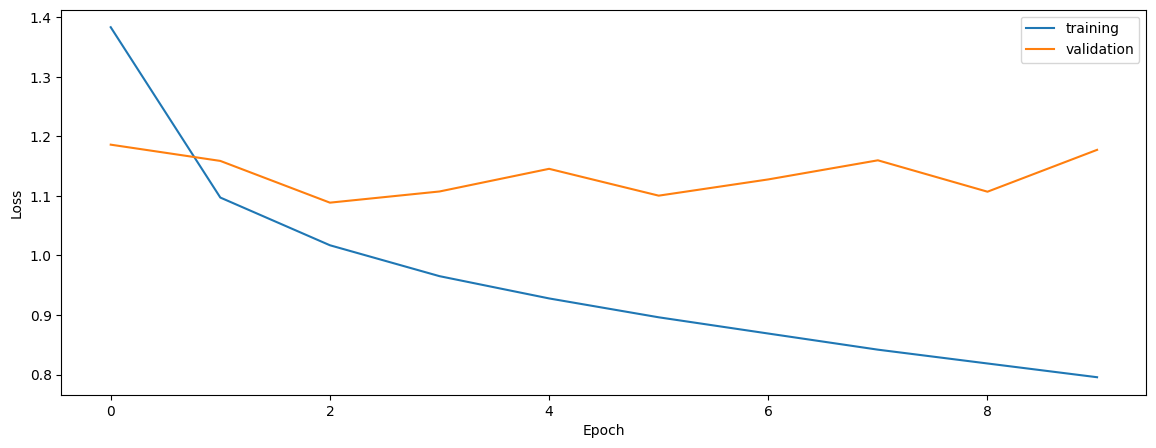

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6197598748672238
0.5729868373447272
0.5627483386103476


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.5844094607954977
0.5781115533562823
0.5309650538807207


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.5823234541743108
0.56947959071405
0.5275724843661171


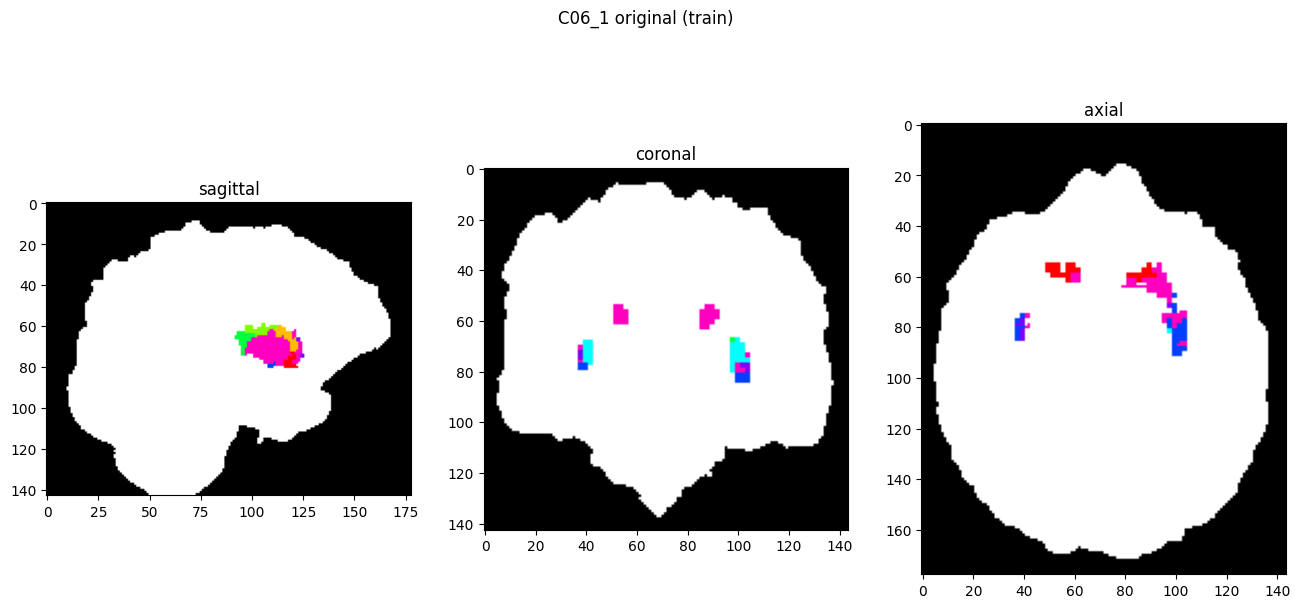

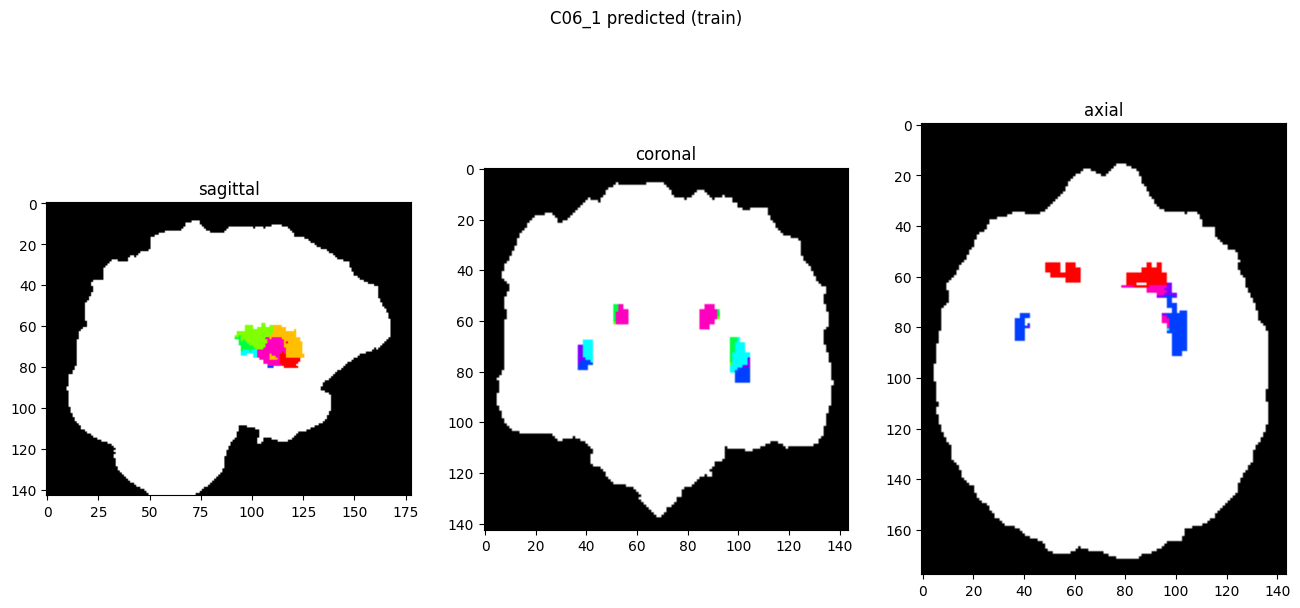

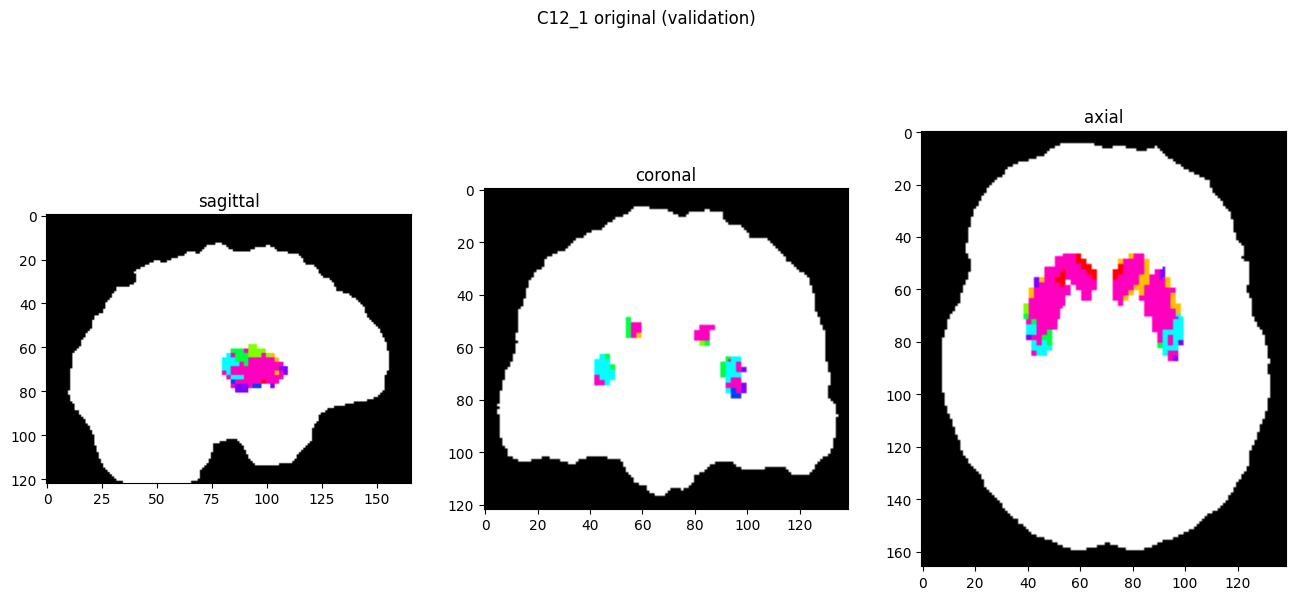

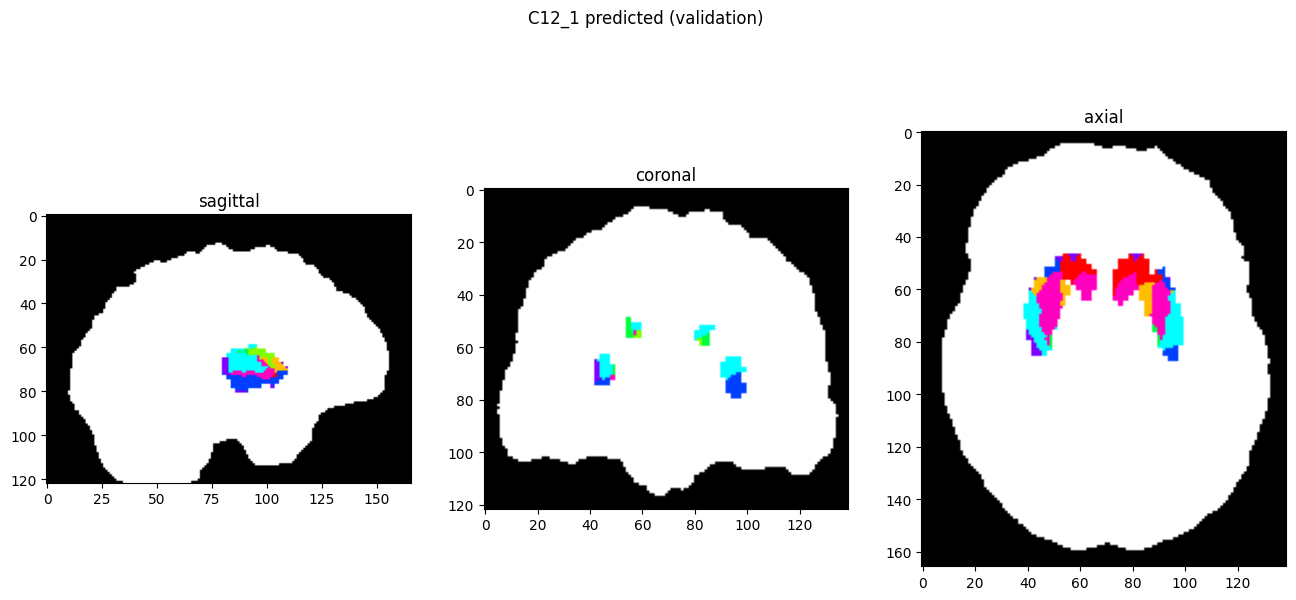

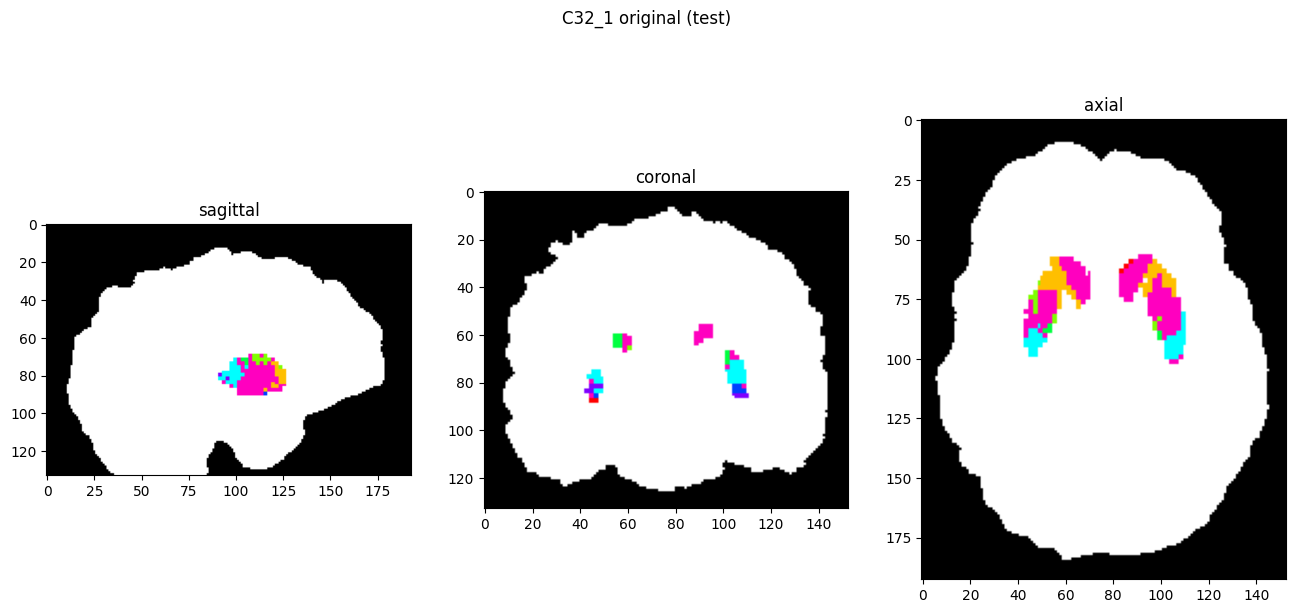

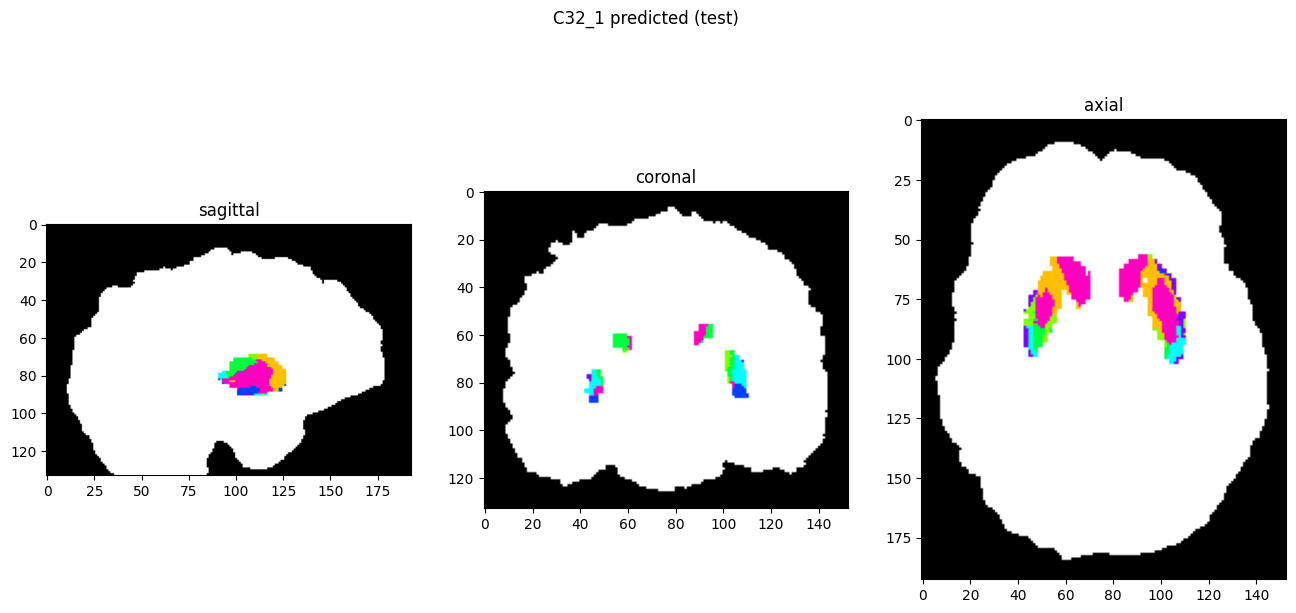

In [10]:
showResults(model, gen, threshold=0)